## Events Analysis

This notebook looks at changes around major U.S. events: 9/11, the 2008 Financial Crisis, and the 2016 election.

### Import packages and load data

In [1]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import nltk
import seaborn as sns

import os #For looking through files
import os.path #For managing file paths

from ast import literal_eval
import source.helper_functions as helper

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load corpus
file = 'total_trans_normalized.csv'
tal_df = pd.read_csv(file, converters = helper.converters)

In [113]:
tal_df.head()

,ep_num,ep_title,year,url,act_name,text,tokenized_sents,no_lemma_normalized_sents,normalized_sents,tokenized_text,normalized_tokens,no_lemma_normalized_tokens
0,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Four: Act Four,This is Your Radio Playhouse. I'm Ira Glass. O...,"[[This, is, Your, Radio, Playhouse], [I, 'm, I...","[[radio, playhouse], [m, ira, glass], [ok, rig...","[[radio, playhouse], [be, ira, glass], [okay, ...","[This, is, Your, Radio, Playhouse, I, 'm, Ira,...","[radio, playhouse, be, ira, glass, okay, right...","[radio, playhouse, m, ira, glass, ok, right, r..."
1,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Three: Act Three,"Well, next on our little playhouse stage, we h...","[[Well, next, on, our, little, playhouse, stag...","[[little, playhouse, stage, mr, lawrence, steg...","[[little, playhouse, stage, mr, lawrence, steg...","[Well, next, on, our, little, playhouse, stage...","[little, playhouse, stage, mr, lawrence, stege...","[little, playhouse, stage, mr, lawrence, stege..."
2,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act Two: Act Two,"Good morning. Glass, Jacobson & Associates.Hey...","[[Good, morning], [Glass, Jacobson, Associates...","[[good, morning], [glass, jacobson, associates...","[[good, morning], [glass, jacobson, associate]...","[Good, morning, Glass, Jacobson, Associates, H...","[good, morning, glass, jacobson, associate, he...","[good, morning, glass, jacobson, associates, h..."
3,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Act One: Act One,"All right, Your Radio Playhouse. All right. I'...","[[All, right, Your, Radio, Playhouse], [All, r...","[[right, radio, playhouse], [right], [m, makin...","[[right, radio, playhouse], [right], [be, make...","[All, right, Your, Radio, Playhouse, All, righ...","[right, radio, playhouse, right, be, make, eye...","[right, radio, playhouse, right, m, making, ey..."
4,1,New Beginnings,1995,https://www.thisamericanlife.org/1/transcript,Prologue,"Joe Franklin?I'm ready.It's Ira Glass here.Oh,...","[[Joe, Franklin?I'm, ready], [It, 's, Ira, Gla...","[[joe, franklin?i'm, ready], [ira, glass], [oh...","[[joe, franklin?i'm, ready], [ira, glass], [oh...","[Joe, Franklin?I'm, ready, It, 's, Ira, Glass,...","[joe, franklin?i'm, ready, ira, glass, oh, emc...","[joe, franklin?i'm, ready, ira, glass, oh, emc..."


## Event 2: Financial Crisis

### First, split it up by year
before = 2005, 2006, 2007

after = 2008, 2009, 2010

In [4]:
before = [2005, 2006, 2007]
after = [2008, 2009, 2010]
before_df = tal_df[tal_df['year'].isin(before)]
after_df = tal_df[tal_df['year'].isin(after)]
by_year = {}
for year in before + after:
    by_year[year] = tal_df[tal_df['year'] == year]

## Subject/object for verbs

In [17]:
pre = helper.make_verb_dict('hate', before_df)
pre

{'2005': (['who',
   'farmers',
   'I',
   'I',
   'Collin',
   'I',
   'I',
   'People',
   'I',
   'you',
   'you',
   'I',
   'I',
   'people',
   'You',
   'they'],
  ['them',
   'Hawks',
   'country',
   'him',
   'customer',
   'dogs',
   'me',
   'me',
   'them',
   'sports',
   'soccer',
   'soccer',
   'States',
   'you',
   'us']),
 '2006': (['I',
   'people',
   'they',
   'they',
   'I',
   'I',
   'I',
   'who',
   'they',
   'Muslims'],
  ['Americans',
   'SOUL',
   'SOUL',
   'it',
   'someone',
   'her',
   'her',
   'her',
   'you',
   'us']),
 '2007': (['daughter',
   'I',
   'I',
   'she',
   'I',
   'I',
   'I',
   'I',
   'I',
   'They',
   'I',
   'I',
   'I',
   'I',
   'I'],
  ['me', 'life', 'me', 'you', 'man', 'Iran', 'classes', 'friend'])}

In [21]:
post = helper.make_verb_dict('hate', after_df)
post

{'2008': (['I',
   'I',
   'I',
   'you',
   'you',
   'I',
   'I',
   'she',
   'I',
   'We',
   'We',
   'we',
   'I',
   'I',
   'I',
   'I',
   'I',
   'banks',
   'institutions',
   'I',
   'people',
   'us',
   'you',
   'I',
   'You'],
  ['him',
   'word',
   'article',
   'wall',
   'daughter',
   'him',
   'stereotypes',
   'them',
   'Muslims',
   'country',
   'it',
   'idea',
   'idea',
   'idea',
   'you',
   'Russians',
   'people']),
 '2009': (['you',
   'I',
   'Everyone',
   'I',
   'I',
   'They',
   'I',
   'I',
   'I',
   'I',
   'I',
   'you',
   'I',
   'you',
   'people',
   'lawyers',
   'You',
   'I',
   'We',
   'you',
   'they',
   'lot',
   'I',
   'you',
   'I',
   'you',
   'I',
   'People'],
  ['him',
   'him',
   'him',
   'it',
   'nationalization',
   'folks',
   'what',
   'name',
   'what',
   'name',
   'me',
   'Citigroup',
   'lawyers',
   'Poof',
   'family',
   'catalyst',
   'it',
   'insurers',
   'copays',
   'you',
   'me',
   'day',
   'day

In [22]:
feel_pre = helper.make_verb_dict('feel', before_df)
feel_pre

{'2005': (['you',
   'I',
   'I',
   'you',
   'I',
   'we',
   'us',
   'them',
   'you',
   'me',
   'you',
   'I',
   'you',
   'you',
   'I',
   'editors',
   'her',
   'me',
   'I',
   'I',
   'I',
   'I',
   'you',
   'I',
   'you',
   'you',
   'He',
   'they',
   'him',
   'me',
   'I',
   'you',
   'I',
   'me',
   'I',
   'I',
   'I',
   'parents',
   'I',
   'father',
   'you',
   'I',
   'you',
   'I',
   'you',
   'me',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'husband',
   'I',
   'I',
   'myself',
   'you',
   'I',
   'I',
   'I',
   'You',
   'I',
   'you',
   'I',
   'I',
   'I',
   'I',
   'you',
   'you',
   'me',
   'I',
   'you',
   'you',
   'you',
   'me',
   'I',
   'you',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'You',
   'guys',
   'me',
   'you',
   'me',
   'me',
   'you',
   'I',
   'I',
   'I',
   'I',
   'me',
   'me',
   'they',
   'I',
   'people',
   'I',
   'I',
   'you',
   'you',
   'I',
   'you',
   'I',
   'I',
   'you',
   'I'

In [23]:
feel_post = helper.make_verb_dict('feel', after_df)
feel_post

{'2008': (['us',
   'You',
   'I',
   'you',
   'we',
   'they',
   'they',
   'I',
   'I',
   'I',
   'I',
   'It',
   'who',
   'me',
   'I',
   'me',
   'you',
   'I',
   'you',
   'I',
   'me',
   'you',
   'house',
   'I',
   'they',
   'we',
   'you',
   'You',
   'I',
   'parents',
   'Davidson',
   'I',
   'you',
   'you',
   'you',
   'I',
   'I',
   'she',
   'I',
   'I',
   'I',
   'you',
   'I',
   'You',
   'somebody',
   'they',
   'you',
   'me',
   'I',
   'They',
   'someone',
   'I',
   'He',
   'I',
   'You',
   'years',
   'it',
   'them',
   'I',
   'you',
   'you',
   'I',
   'I',
   'me',
   'she',
   'mom',
   'you',
   'we',
   'he',
   'I',
   'he',
   'I',
   'I',
   'I',
   'I',
   'me',
   'them',
   'you',
   'you',
   'I',
   'you',
   'you',
   'you',
   'you',
   'I',
   'I',
   'I',
   'you',
   'I',
   'everybody',
   'who',
   'I',
   'it',
   'me',
   'you',
   'me',
   'People',
   'you',
   'I',
   'I',
   'I',
   'I',
   'I',
   'him',
   'me',
 

## Get common_contexts across years for a particular words

In [39]:
# words of interest for this event
word1 = ['security', 'secure', 'money', 'financial', 'crisis',
         'bank', 'debt', 'rate', 'bailout', 'government', 'loan',
         'mortgage', 'panic', 'banking', 'housing', 'finances']
word2 = ['love', 'america', 'american', 'country', 'safe', 'family', 'home']

In [137]:
financial_home_contexts = helper.agg_contexts(list(by_year.values()),
                                              before + after, word1+word2)

In [139]:
financial_home_contexts

,security,secure,money,financial,crisis,bank,debt,rate,bailout,government,...,housing,finances,love,america,american,country,safe,family,home,year
0,"[(basically, stability), (year, situation), (g...","[(quote, people), (feel, afraid), (feel, fbi),...","[(collect, money), (money, poor), (extra, week...","[(need, aid), (school, aid)]","[(real, mom), (real, real), (social, cambodia)]","[(west, volunteering), (store, account), (went...","[(got, city), (long, saves), (gone, tried)]","[(crime, soaring), (crime, fact), (crime, big)...",[],"[(parts, existed), (charge, usaid), (federal, ...",...,"[(robedee, lawyer), (murderer, lawyer), (mainl...",[],"[(iraq, brings), (helicopters, love), (love, p...","[(trip, seen), (people, lot), (rest, lot), (sc...","[(ah, know), (going, forces), (chicago, life),...","[(years, feel), (phase, figured), (arrived, ap...","[(yeah, wait), (men, joe), (look, atmosphere),...","[(house, talked), (got, going), (save, win), (...","[(iraq, wbez), (good, relax), (job, yeah), (wa...",2005
1,"[(hours, guards), (young, guard), (little, boo...",[],"[(pool, $), (everybody, reason), (going, katie...","[(wife, problems), (reassuring, mess), (crises...","[(aids, promise)]","[(money, small), (copy, statement), (letters, ...",[],"[(death, gone)]",[],"[(regard, rules), (federal, like), (federal, r...",...,"[(public, projects), (department, urban), (big...",[],"[(yeah, instinct), (ve, fact), (zharov, radica...","[(morning, actually), (morning, davy), (mrs, m...","[(*START*, life), (chicago, life), (programs, ...","[(folks, found), (stuff, world), (stations, ta...","[(think, assume), (love, dad), (feel, house), ...","[(makes, suffering), (talking, acknowledge), (...","[(got, messages), (chick, brooklyn), (like, ni...",2006
2,"[(peter, camera), (couple, guards), (need, sta...","[(held, room)]","[(knew, coming), (coming, basically), (got, pr...","[(handled, crime), (microwaves, account), (uni...","[(midst, desperate), (kind, like), (knows, fin...","[($, buy), (attorney, account), (credit, texas...","[(worth, house), ($, oh), (let, happen), (deep...","[(mortality, pilgrims), (incidentals, m), (sec...",[],"[(average, ministry), (blocked, united), (stat...",...,"[(finding, ready), (public, complex)]","[(lay, paying), (like, break), (candid, major)]","[(time, beer), (audiences, point), (think, it-...","[(weight, probably), (little, comes), (returni...","[(chicago, life), (south, cattle), (continues,...","[(smuggle, care), (like, sort), (half, vote), ...","[(totally, wander--), (clever, city), (relativ...","[(expect, member), (feel, prayers), (percentil...","[(going, care), (media, reply), (came, work), ...",2007
3,"[(corporate, consultant), (national, purposes)...","[(clear, coming), (money, main), (rushed, room)]","[(offer, illegal), (tell, years), (sir, sir), ...","[(working, services), (awards, securities), (g...","[(mortgage, time), (credit, gave), (mortgage, ...","[(dad, account), (personal, account), (like, a...","[(collateralized, obligation), (went, late), (...","[(month, decades), (adjustable, recently), (re...","[(crisis, fannie), (step, banks), ($, package)...","[(big, institution), (build, funded), (facilit...",...,"[(public, auctioned), (loan, crisis), (crisis,...",[],"[(promise, care), (sure, know), (stranger, joh...","[(flying, divorce), (report, runs), (onion, fe...","[(memoir, life), (met, aid), (chicago, life), ...","[(miriam, week), (countries, easy), (happened,...","[(brother, speaking), (blanket, inch), (bought...","[(said, want), (bad, think), (good, looked), (...","[(wonderful, lied), (coming, round), (going, w...",2008
4,"[(social, allotment), (working, inauguration),...","[(way, tell), (need, chimpanzee)]","[(audience, popularity), (mayor, care), (spend...","[(exotic, instruments), (residing, institution...","[(mortgage, year), (understand, right), (banki...","[(central, fed), (central, raised), (overnight...","[($, pay), (residential, basically), (wipe, al...","[(funds, half), (interest, setting), (lendi

In [141]:
financial_home_contexts.to_csv('financial_common_contexts.csv', index=False)

In [176]:
# count words in contexts
context_counts = helper.count_contexts(list(by_year.values()),
                                       before + after, word1+word2)

In [167]:
context_counts

,security,secure,money,financial,crisis,bank,debt,rate,bailout,government,loan,mortgage,panic,banking,housing,finances,year
0,"{'social': 5, 'homeland': 5, 'national': 3, 'f...","{'feel': 2, 'quote': 1, 'people': 1, 'afraid':...","{'money': 8, 'need': 8, 'lot': 8, 'going': 7, ...","{'aid': 2, 'need': 1, 'school': 1}","{'real': 3, 'mom': 1, 'social': 1, 'cambodia': 1}","{'west': 4, 'like': 2, 'storefront': 2, 'bank'...","{'got': 1, 'city': 1, 'long': 1, 'saves': 1, '...","{'crime': 3, 'soaring': 1, 'fact': 1, 'big': 1...",{},"{'federal': 6, 'christian': 3, 'volunteers': 3...","{'money': 2, 'qualify': 1, 'months': 1, 'bank'...",{},"{'close': 1, 'basically': 1, 'run': 1, 'standi...",{},"{'center': 6, 'lawyer': 2, 'department': 2, 'f...",{},2005
1,"{'booth': 2, 'hours': 1, 'guards': 1, 'young':...",{},"{'going': 4, 'lot': 4, 'people': 4, 'dig': 3, ...","{'wife': 1, 'problems': 1, 'reassuring': 1, 'm...","{'aids': 1, 'promise': 1}","{'west': 5, 'money': 1, 'small': 1, 'copy': 1,...",{},"{'death': 1, 'gone': 1}",{},"{'federal': 4, 'building': 3, 'rules': 2, 'law...",{},"{'paid': 1, 'bungalow': 1, 'statements': 1, 's...","{'remorse': 1, 'instant': 1, 'started': 1, 're...",{},"{'public': 7, 'activists': 3, 'projects': 2, '...",{},2006
2,"{'assessment': 2, 'national': 2, 'security': 2...","{'held': 1, 'room': 1}","{'money': 10, 'lot': 9, 'like': 4, '$': 4, 'co...","{'aid': 3, 'hardship': 2, 'handled': 1, 'crime...","{'like': 2, 'midst': 1, 'desperate': 1, 'kind'...","{'$': 2, 'account': 2, 'buy': 1, 'attorney': 1...","{'deep': 2, 'worth': 1, 'house': 1, '$': 1, 'o...","{'mortality': 1, 'pilgrims': 1, 'incidentals':...",{},"{'work': 3, 'air': 3, 'maliki': 3, 'federal': ...","{'student': 1, 'apply': 1}",{},"{'confuse': 1, 'excitement': 1, 'running': 1, ...","{'borders': 1, 'system': 1}","{'finding': 1, 'ready': 1, 'public': 1, 'compl...","{'lay': 1, 'paying': 1, 'like': 1, 'break': 1,...",2007
3,"{'backed': 5, 'national': 4, 'homeland': 4, 's...","{'clear': 1, 'coming': 1, 'money': 1, 'main': ...","{'pool': 23, 'lot': 14, 'borrow': 14, 'making'...","{'system': 11, 'crisis': 7, 'markets': 5, 'glo...","{'financial': 8, 'mortgage': 7, 'housing': 4, ...","{'like': 8, 'small': 7, 'account': 5, 'money':...","{'like': 2, 'collateralized': 1, 'obligation':...","{'money': 3, 'interest': 3, 'recently': 2, 'fi...","{'plan': 3, 'bill': 3, 'good': 3, 'support': 2...","{'federal': 8, 'want': 4, 'states': 3, 'agency...","{'money': 3, 'imprudent': 3, 'buy': 3, 'nina':...","{'backed': 13, 'crisis': 6, 'state': 5, 'broke...","{'fear': 3, 'state': 1, 'hear': 1, 'start': 1,...","{'system': 4, 'industry': 3, 'housing': 2, 'se...","{'crisis': 4, 'market': 4, 'bubble': 3, 'price...",{},2008
4,"{'backed': 5, 'national': 3, 'chain': 2, 'soci...","{'way': 1, 'tell': 1, 'need': 1, 'chimpanzee': 1}","{'pool': 32, 'lot': 17, 'planet': 12, 'big': 9...","{'products': 9, 'instruments': 4, 'institution...","{'banking': 6, 'housing': 4, 'mortgage': 2, 'r...","{'clark': 21, '$': 13, 'deutsche': 8, 'money':...","{'pay': 2, 'collateralized': 2, '$': 1, 'resid...","{'interest': 5, 'inflation': 3, 'funds': 2, 'l...","{'keeping': 1, 'money': 1}","{'going': 5, 'federal': 5, 'people': 5, 'says'...","{'savings': 5, 'modifications': 5, '$': 4, 'ho...","{'backed': 14, 'payment': 4, 'paid': 4, 'broke...","{'investors': 1, 'pull': 1, 'butler': 1, 'eyes...","{'system': 14, 'crisis': 6, 'joke': 2, 'busine...","{'prices': 6, 'bubble': 5, 'market': 4, 'crisi...","{'prioritization': 1, 'people': 1}",2009
5,"{'backed': 3, 'forces': 2, 'maximum': 2, 'fina...","{'able': 1, 'country': 1, 'try': 1, 'dirty': 1}","{'lot': 14, 'planet': 13, 'going': 10, 'people...","{'crisis': 12, 'system': 8, 'collapse': 2, 'in...","{'financial': 12, 'midlife': 5, 'fiscal': 4, '...","{'$': 3, 'world': 3, 'central': 3, 'investment...","{'card': 2, 'collateralized': 1, 'obligations'...","{'inflation': 3, 'drop': 2, 'dropout': 2, 'wan...","{'history': 1, 'cost': 1, 'government': 1, 'lo...","{'iraqi': 11, 'federal':

In [175]:
for idx in range(len(before + after)):
    print(context_counts.iloc[idx]['financial'])
    print()

OrderedDict([('aid', 2), ('need', 1), ('school', 1)])

OrderedDict([('wife', 1), ('problems', 1), ('reassuring', 1), ('mess', 1), ('crises', 1), ('difficulty', 1)])

OrderedDict([('aid', 3), ('hardship', 2), ('handled', 1), ('crime', 1), ('microwaves', 1), ('account', 1), ('universities', 1), ('tuition', 1), ('type', 1), ('mean', 1), ('businessman', 1), ('plan', 1), ('worth', 1), ('records', 1), ('holidays', 1)])

OrderedDict([('system', 11), ('crisis', 7), ('markets', 5), ('global', 3), ('turmoil', 3), ('institutions', 3), ('mess', 3), ('services', 2), ('sort', 2), ('thing', 2), ('products', 2), ('regulators', 2), ('current', 2), ('working', 1), ('awards', 1), ('securities', 1), ('talking', 1), ('instrument', 1), ('alchemy', 1), ('head', 1), ('engineering', 1), ('specialized', 1), ('techniques', 1), ('non', 1), ('terrorism', 1), ('people', 1), ('involved', 1), ('transactions', 1), ('sounding', 1), ('america', 1), ('upheaval', 1), ('big', 1), ('deal', 1), ('recent', 1), ('risky', 1), (

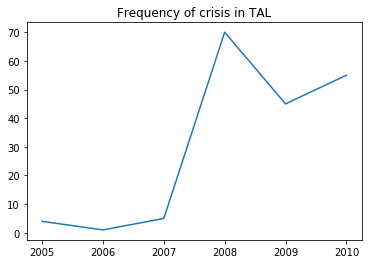

In [145]:
helper.plot_count(tal_df, before + after, 'crisis')

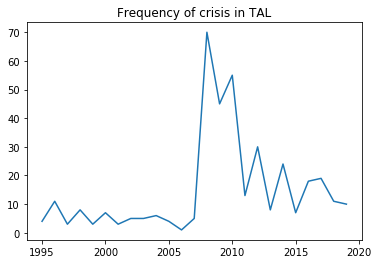

In [155]:
helper.plot_count(tal_df, tal_df['year'].unique(), 'crisis')

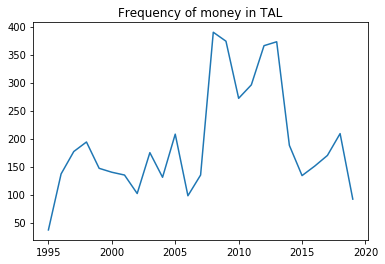

In [149]:
helper.plot_count(tal_df, tal_df['year'].unique(), 'money')

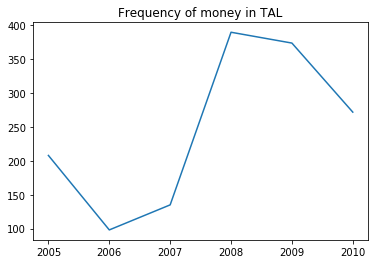

In [146]:
helper.plot_count(tal_df, before + after, 'money')

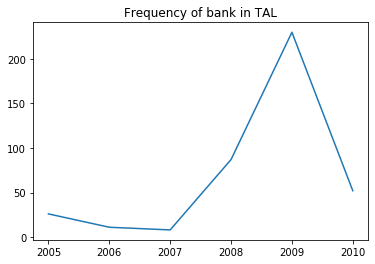

In [27]:
helper.plot_count(tal_df, before + after, 'bank')

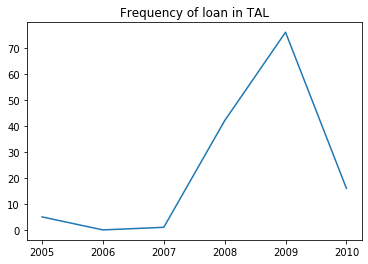

In [28]:
helper.plot_count(tal_df, before + after, 'loan')

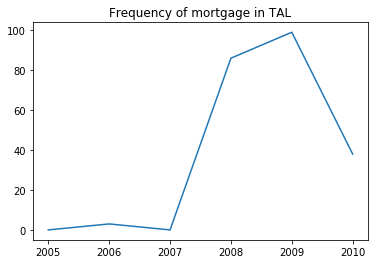

In [29]:
helper.plot_count(tal_df, before + after, 'mortgage')

## Most Common Adj

In [32]:
for year in by_year.keys():
    df = by_year[year]
    res = helper.most_common_adj(df, 'bank')
    print(year)
    print(res)
    print()

2005
{'storefront': 2}

2006
{}

2007
{}

2008
{'personal': 1, 'central': 2, 'small': 4, 'big': 2, 'Nigerian': 1, 'commercial': 1, 'major': 1, 'fashioned': 1, 'successful': 2}

2009
{'central': 2, 'overnight': 1, 'hypothetical': 1, 'complicated': 1, 'other': 2, 'large': 2, 'major': 2, 'big': 2, 'bad': 1, 'total': 1, 'many': 1, 'young': 1, 'entire': 1, 'small': 3, 'little': 1, 'anti': 1, 'federal': 1, 'expensive': 2, 'national': 1}

2010
{'great': 1, 'regional': 1, 'big': 1, 'triple': 1, 'local': 1, 'international': 1}



In [33]:
for year in by_year.keys():
    df = by_year[year]
    res = helper.most_common_adj(df, 'loan')
    print(year)
    print(res)
    print()

2005
{}

2006
{}

2007
{}

2008
{'official': 1}

2009
{'Average': 1, 'original': 1, 'assistant': 1, 'other': 1, 'big': 2, 'official': 1}

2010
{}



In [34]:
for year in by_year.keys():
    df = by_year[year]
    res = helper.most_common_adj(df, 'government')
    print(year)
    print(res)
    print()

2005
{'federal': 6, 'anti': 1, 'secret': 1, 'secular': 1, 'Christian': 3, 'civil': 1, 'American': 3, 'own': 3, 'special': 2, 'local': 2, 'navigate': 1, 'only': 1, 'Burmese': 1}

2006
{'federal': 4, 'new': 1, 'mock': 1}

2007
{'average': 1, 'Iraqi': 2, 'rational': 1, 'local': 1, 'communist': 1, 'new': 1, 'American': 1, 'secular': 1, 'Maliki': 1, 'British': 2, 'federal': 3}

2008
{'big': 2, 'federal': 7, 'unitary': 1, 'Canadian': 1, 'other': 1, 'own': 1}

2009
{'federal': 4, 'Only': 1, 'efficient': 1, 'own': 3, 'Colombian': 1, 'Vietnamese': 1, 'big': 1, 'top': 1, 'special': 2, 'American': 2, 'enough': 1}

2010
{'big': 1, 'Colombian': 1, 'special': 1, 'Barbadian': 1, 'Jamaican': 1, 'Czech': 1, 'different': 1, 'federal': 5, 'Iraqi': 11, 'central': 1, 'small': 1, 'huge': 1, 'British': 1}



In [35]:
for year in by_year.keys():
    df = by_year[year]
    res = helper.most_common_adj(df, 'money')
    print(year)
    print(res)
    print()

2005
{'extra': 4, 'enough': 9, 'decent': 1, 'good': 2, 'much': 10, 'federal': 3, 'big': 2, 'small': 2, 'precious': 1}

2006
{'little': 1, 'Good': 2, 'much': 4, 'decent': 1, 'enough': 2}

2007
{'big': 1, 'own': 3, 'enough': 2, 'decent': 1, 'much': 4, 'good': 1}

2008
{'much': 20, 'international': 1, 'enough': 5, 'new': 1, 'own': 1, 'equivalent': 1, 'good': 1, 'little': 3, 'real': 1, 'single': 1, 'extra': 2, 'other': 1, 'institutional': 1, 'possible': 2, 'Good': 2, 'same': 1}

2009
{'enough': 4, 'much': 19, 'own': 4, 'little': 2, 'extra': 4, 'big': 6, 'small': 2, 'decent': 1, 'new': 2, 'Good': 1, 'loose': 1, 'enormous': 2, 'spectacular': 1}

2010
{'big': 2, 'spectacular': 1, 'extra': 1, 'much': 10, 'easy': 1, 'foreign': 1, 'new': 1, 'bogus': 1, 'federal': 2, 'enough': 4, 'stimulus': 2, 'grant': 1, 'own': 2, 'quick': 1, 'good': 1}



In [112]:
for year in by_year.keys():
    df = by_year[year]
    res = helper.most_common_adj(df, 'crisis')
    print(year)
    print(res)
    print()

/Users/katykoeing/Desktop/computational-content-analysis/nlp-tal/source/helper_functions.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['POS_sents'] = df.apply(lambda x: tag_sents_pos(x['tokenized_sents']), axis=1)


2005
{'real': 3, 'social': 1}

2006
{}

2007
{'own': 1, 'existential': 1}

2008
{'prime': 1, 'whole': 3, 'financial': 10, 'recent': 1, 'economic': 4, 'global': 1, 'scary': 1, 'current': 1, 'bad': 2, 'subprime': 2}

2009
{'current': 2, 'regional': 1, 'global': 2, 'foreclosure': 1, 'economic': 2, 'real': 2, 'huge': 1, 'whole': 1, 'financial': 2}

2010
{'financial': 12, 'massive': 2, 'fiscal': 5, 'identical': 1, 'economic': 1}



## Word Networks

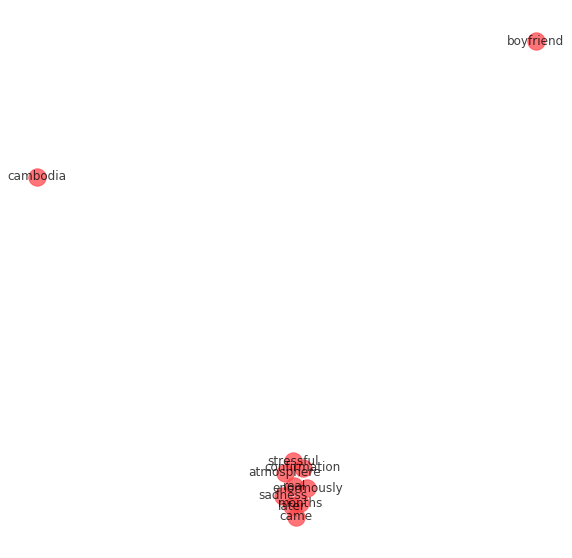

In [157]:
# crisis not in pre-financial crisis vocab
helper.graph_nx_word(before_df, 'no_lemma_normalized_sents', 1, 'crisis')

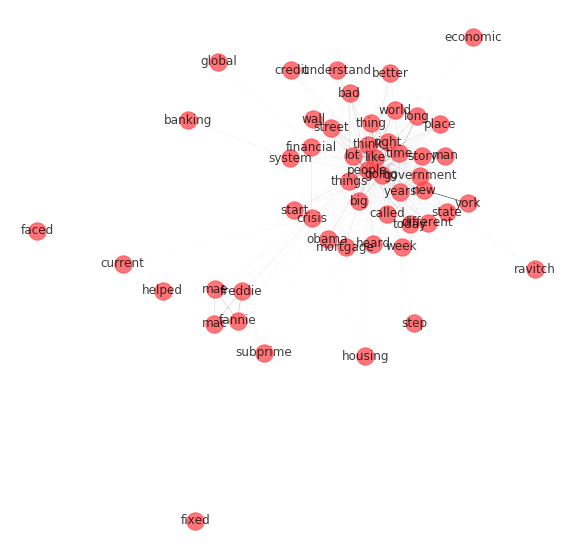

In [158]:
helper.graph_nx_word(after_df, 'no_lemma_normalized_sents', 5, 'crisis')

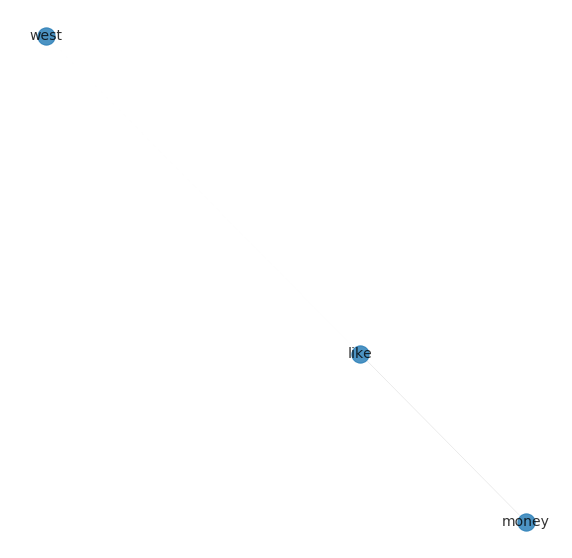

In [12]:
helper.graph_nx_word(before_df, 'no_lemma_normalized_sents', 5, 'bank')

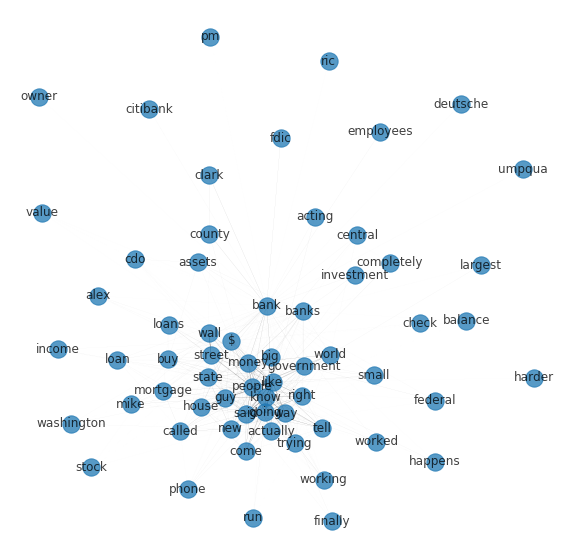

In [130]:
helper.graph_nx_word(after_df, 'no_lemma_normalized_sents', 7, 'bank')

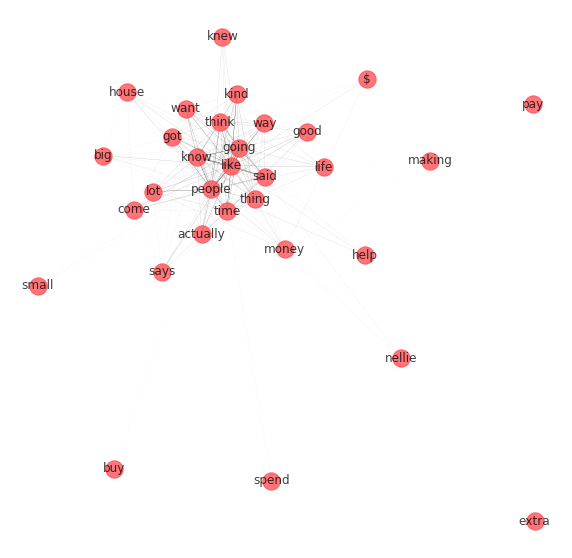

In [159]:
helper.graph_nx_word(before_df, 'no_lemma_normalized_sents', 10, 'money')

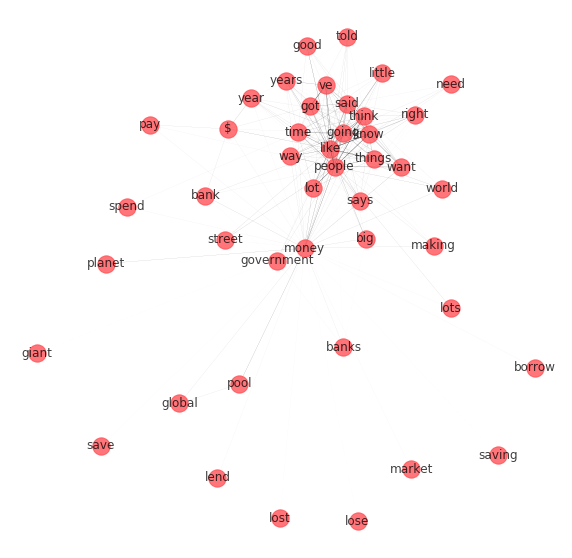

In [160]:
helper.graph_nx_word(after_df, 'no_lemma_normalized_sents', 20, 'money')

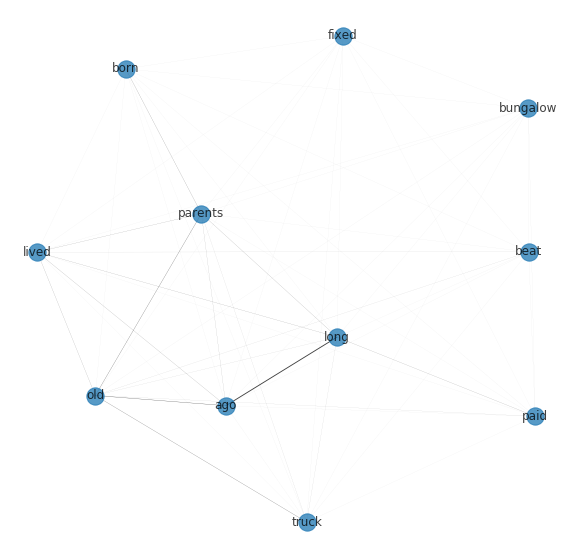

In [36]:
# mortgage not in this corpus
helper.graph_nx_word(before_df, 'no_lemma_normalized_sents', 1, 'mortgage')

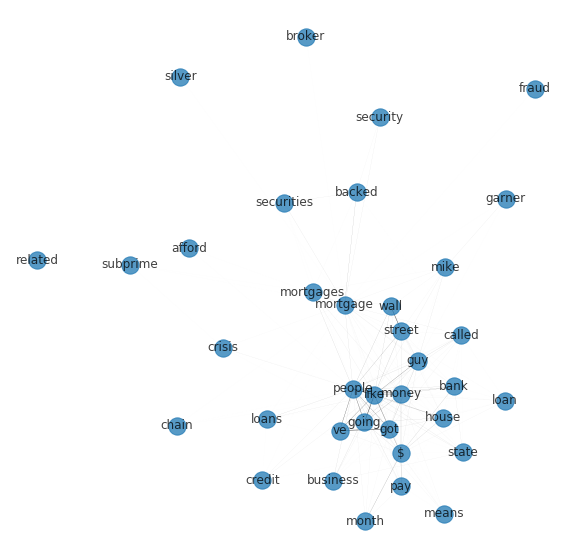

In [143]:
helper.graph_nx_word(after_df, 'no_lemma_normalized_sents', 8, 'mortgage')

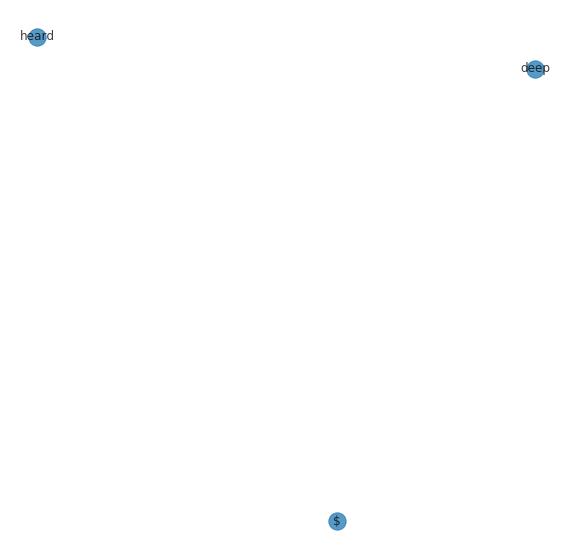

In [31]:
helper.graph_nx_word(before_df, 'no_lemma_normalized_sents', 1, 'debt')

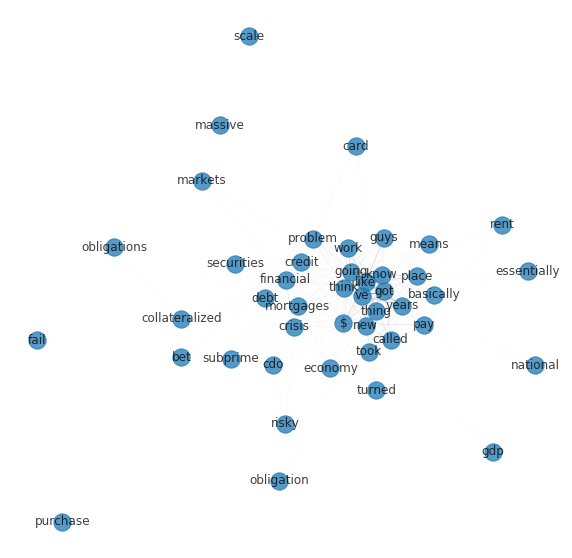

In [32]:
helper.graph_nx_word(after_df, 'no_lemma_normalized_sents', 1, 'debt')

## Embedding Bias

In [25]:
# create representative group 
# male
male = ['he', 'son', 'boys', 'boy', 'male', 'man', 'men', 'his', 'nephew',
        'nephews', 'brother', 'brothers', 'father', 'uncle', 'uncles', 'himself']
# female, from the Garg paper
female = ['she', 'daughter', 'hers', 'her', 'mother', 'woman', 'girl', 'herself',
          'female', 'females', 'sister', 'daughters', 'mothers',
          'women', 'girls', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
# rich
rich = ['rich', 'wealthy', 'wealth', 'expensive', 'affluent', 'affluence', 'afford']
# poor
poor = ['poor', 'cheap', 'poverty', 'broke']

In [26]:
# pre
talW2V = gensim.models.word2vec.Word2Vec(before_df['no_lemma_normalized_sents'].sum(), 
                                         size=1000)
male_vec = helper.mk_rep_group_vec(talW2V, male)
female_vec = helper.mk_rep_group_vec(talW2V, female)
rich_vec = helper.mk_rep_group_vec(talW2V, rich)
poor_vec = helper.mk_rep_group_vec(talW2V, poor)

In [27]:
# now try on post
talW2V01 = gensim.models.word2vec.Word2Vec(after_df['no_lemma_normalized_sents'].sum(),
                                           size=1000)
male_vec01 = helper.mk_rep_group_vec(talW2V01, male)
female_vec01 = helper.mk_rep_group_vec(talW2V01, female)
rich_vec01 = helper.mk_rep_group_vec(talW2V01, rich)
poor_vec01 = helper.mk_rep_group_vec(talW2V01, poor)

In [33]:
# neutral word list
liberal = ['liberal', 'progressive', 'democrat'] 
conservative = ['conservative', 'republican']
finance = ['save', 'savings', 'loan', 'debt', 'bank',
           'banking', 'mortgage', 'money']
anger = ['angry', 'mad', 'hate', 'anger', 'disgust']
fear = ['scared', 'fear', 'scary', 'afraid']
happy = ['happy', 'excited', 'enjoy', 'enjoying']
sad = ['sad', 'unhappy', 'tears']

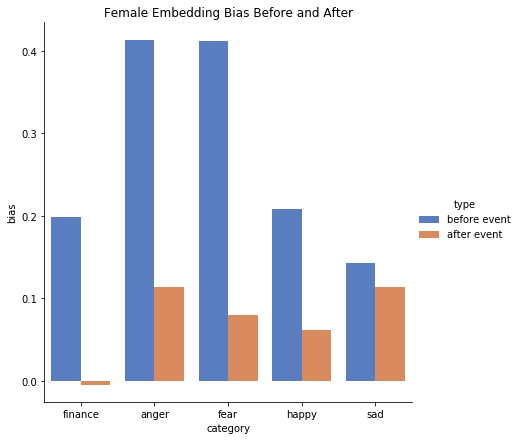

In [34]:
wordlist_dict = {'finance': finance, 'anger': anger,
                 'fear': fear, 'happy': happy, 'sad': sad}
pre_dict = {'model': talW2V, 'group_vec': female_vec,
            'compare_vec': male_vec}
post_dict = {'model': talW2V01, 'group_vec': female_vec01,
             'compare_vec': male_vec01}

helper.plot_bias(pre_dict, post_dict,
                 'Female Embedding Bias Before and After',
                 wordlist_dict)

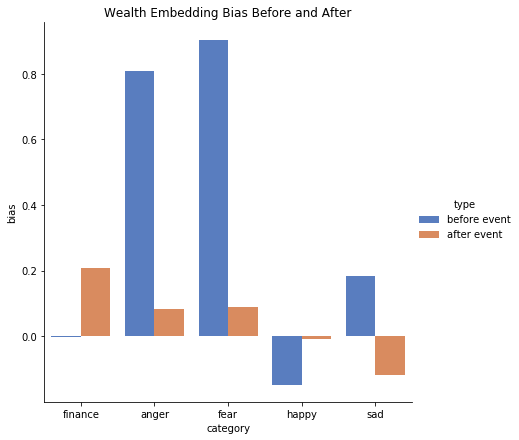

In [38]:
wordlist_dict = {'finance': finance, 'anger': anger,
                 'fear': fear, 'happy': happy, 'sad': sad}
pre_dict = {'model': talW2V, 'group_vec': poor_vec,
            'compare_vec': rich_vec}
post_dict = {'model': talW2V01, 'group_vec': poor_vec01,
             'compare_vec': rich_vec01}

helper.plot_bias(pre_dict, post_dict,
                 'Wealth Embedding Bias Before and After',
                 wordlist_dict)

## Most similar

In [114]:
most_similar_crisis = helper.agg_sim_words([talW2V, talW2V01], ['before crisis', 'after crisis'], word1 + word2)
most_similar_crisis.head()

,security,secure,money,financial,crisis,bank,debt,rate,bailout,government,...,housing,finances,love,america,american,country,safe,family,home,period
0,"[(government, 0.9999810457229614), (john, 0.99...","[(problem, 0.999737560749054), (knows, 0.99972...","[(asked, 0.9998542070388794), (says, 0.9998446...","[(quote, 0.9999390244483948), (english, 0.9999...","[(congress, 0.9998593330383301), (team, 0.9998...","[(team, 0.9999727606773376), (history, 0.99997...","[(straight, 0.9998313188552856), (box, 0.99983...","[(trial, 0.9998042583465576), (area, 0.9998041...",NA,"[(security, 0.9999810457229614), (survey, 0.99...",...,"[(schools, 0.9999614953994751), (host, 0.99988...",NA,"[(hear, 0.9998795986175537), (snowman, 0.99987...","[(houses, 0.9999626278877258), (jobs, 0.999961...","[(distributed, 0.9986491799354553), (life, 0.9...","[(army, 0.9999700784683228), (iraqi, 0.9999480...","[(immediately, 0.9999719262123108), (store, 0....","[(saw, 0.9998881220817566), (friends, 0.999880...","[(mom, 0.9998267889022827), (away, 0.999794125...",before crisis
1,"[(housing, 0.9999436140060425), (biggest, 0.99...","[(dog, 0.9997067451477051), (sophie, 0.9997044...","[(pay, 0.9948440790176392), (house, 0.99439734...","[(insurance, 0.9997997283935547), (manager, 0....","[(attorney, 0.9997724294662476), (agency, 0.99...","[(pool, 0.9979780912399292), (borrow, 0.997894...","[(asset, 0.9999359846115112), (broker, 0.99993...","[(fancy, 0.9999492168426514), (won, 0.99994146...","[(selling, 0.9996641874313354), (risky, 0.9996...","[(company, 0.9993386268615723), (office, 0.998...",...,"[(security, 0.9999436140060425), (east, 0.9999...","[(center, 0.9997197389602661), (bankruptcy, 0....","[(real, 0.9997302889823914), (true, 0.99972081...","[(secretary, 0.99996018409729), (non, 0.999957...","[(oversight, 0.996796727180481), (radio, 0.996...","[(website, 0.9999153017997742), (written, 0.99...","[(avoid, 0.9999639391899109), (control, 0.9999...","[(past, 0.9998601675033569), (worked, 0.999857...","[(away, 0.9987845420837402), (long, 0.99839752...",after crisis


In [115]:
most_similar_crisis.to_csv('crisis_modst_similar.csv', index=False)

In [ ]:
# how to make this readable? how to visualize?

## Plot Dimensions

In [47]:
# dimensions
Gender = helper.dimension(talW2V, ['man','guy', 'male'],
                          ['woman', 'girl', 'female'])
Race = helper.dimension(talW2V, ['black', 'brown', 'minority'],
                        ['white'])
Class = helper.dimension(talW2V, ['rich', 'expensive', 'wealth'],
                         ['poor', 'cheap', 'poor'])

Morality = helper.dimension(talW2V, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education = helper.dimension(talW2V, ['educated','smart'], 
                             ['dumb','stupid'])
dim_dict = {'gender': Gender, 'race': Race, 'class': Class,
            'morality': Morality, 'education': Education}

In [56]:
# word lists
emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
            'embarrassed', 'hate', 'love', 'anger', 'upset',
            'tired', 'lazy', 'hope']

opinions = ['believe', 'belief', 'perspective', 'opinion',
            'thought', 'think', 'attitude']

self = ['self', 'appearance', 'looks', 'confidence', 'gay',
        'black', 'white', 'american']

rel = ['single', 'divorce', 'divorced', 'family', 'brother',
       'sister', 'children', 'aunt', 'uncle',
       'child', 'wedding', 'married', 'marriage', 'boyfriend',
       'girlfriend', 'partner', 'love']

In [66]:
emotions = ['scared', 'secure', 'nervous', 'hopeful', 'security']
Emodf = helper.makeDF(talW2V, emotions, dim_dict)
Opdf = helper.makeDF(talW2V, opinions, dim_dict)
Selfdf = helper.makeDF(talW2V, self, dim_dict)
Reldf = helper.makeDF(talW2V, rel, dim_dict)

Emotions


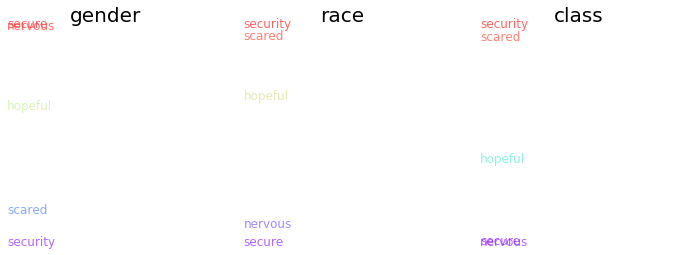

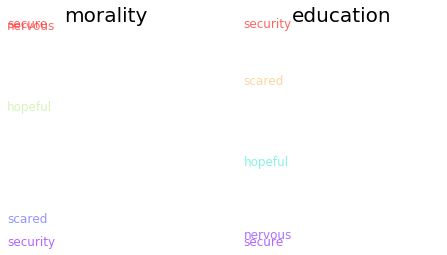

In [67]:
# Pre
# display words on dimensions
print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
helper.PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'education')
plt.show()

In [59]:
# post dimensions
Gender01 = helper.dimension(talW2V01, ['man','guy', 'male','brother','father', 'son'], 
                            ['woman', 'girl', 'female','sister', 'mother','daughter'])
Race01 = helper.dimension(talW2V01, ['black','blacks', 'brown'],
                          ['white', 'whites'])
Class01 = helper.dimension(talW2V01, ['rich', 'expensive', 'wealthy'],
                           ['poor', 'cheap', 'poor'])

Morality01 = helper.dimension(talW2V01, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education01 = helper.dimension(talW2V01, ['educated', 'smart', 'college'], 
                              ['dumb', 'stupid'])
dim_dict01 = {'gender': Gender01, 'race': Race01, 'class': Class01,
              'morality': Morality01, 'education':  Education01}

Emotions


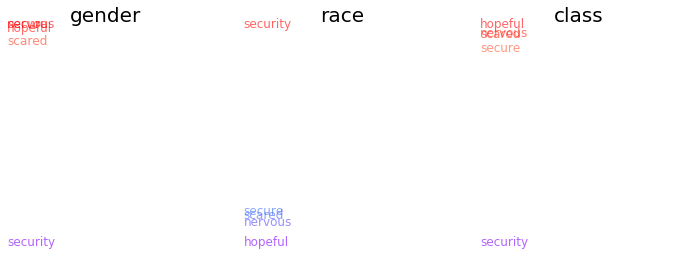

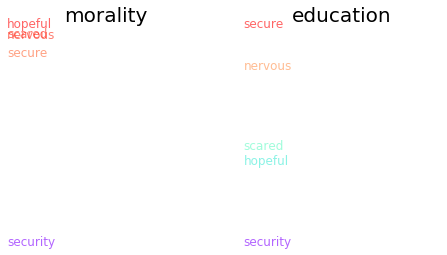

In [68]:
# emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
#             'embarrassed', 'hate', 'love', 'anger', 'upset', 'tired', 'lazy', 'hope']
# same emotions as above
Emodf = helper.makeDF(talW2V01, emotions, dim_dict01)
Opdf = helper.makeDF(talW2V01, opinions, dim_dict01)
Selfdf = helper.makeDF(talW2V01, self, dim_dict01)
Reldf = helper.makeDF(talW2V01, rel, dim_dict01)


print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
helper.PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'education')
plt.show()

## Event 3: 2016 Election

### First, split it up by year
before = 2013, 2014, 2015

after = 2016, 2017, 2018

In [69]:
before_elect = [2013, 2014, 2015]
after_elect = [2016, 2017, 2018]
before_elect_df = tal_df[tal_df['year'].isin(before_elect)]
after_elect_df = tal_df[tal_df['year'].isin(after_elect)]
by_year_elect = {}
for year in before_elect + after_elect:
    by_year_elect[year] = tal_df[tal_df['year'] == year]

## Subject/object for verbs

In [194]:
pre_elect = helper.make_verb_dict('hate', before_elect_df)
helper.order_verb_dict(pre_elect)

{'2013': [{'You': 1, 'They': 1, 'him': 1, 'you': 3, 'we': 1, 'I': 7},
  {'me': 1,
   'you': 1,
   'movie': 1,
   'guts': 1,
   'hair': 1,
   'her': 1,
   'myself': 1}],
 '2014': [{'kid': 1,
   'me': 1,
   'you': 1,
   'they': 1,
   'Doctors': 1,
   'who': 2,
   'I': 11,
   'everyone': 1},
  {'dogs': 2,
   'it': 3,
   'Sunnis': 1,
   'what': 1,
   'job': 1,
   'me': 2,
   'Shia': 1,
   'you': 2,
   'school': 1,
   'question': 1,
   'Jews': 1,
   'them': 1,
   'bitches': 1,
   'name': 1,
   'pay': 1,
   'thing': 1,
   'myself': 1}],
 '2015': [{'You': 1, 'we': 2, 'who': 1, 'I': 18, 'she': 4},
  {'SINGING': 1,
   'person': 1,
   'it': 1,
   'him': 6,
   'me': 1,
   'you': 4,
   'women': 2,
   'her': 1,
   'them': 1}]}

In [193]:
post_elect = helper.make_verb_dict('hate', after_elect_df)
helper.order_verb_dict(post_elect)

{'2016': [{'Dan': 1,
   'We': 1,
   'They': 4,
   'You': 1,
   'me': 2,
   'you': 1,
   'woodpeckers': 1,
   'they': 2,
   'BLEEP': 1,
   'I': 14,
   'she': 1},
  {'everything': 2,
   'world': 1,
   'Kirk': 1,
   'people--': 1,
   'kids': 1,
   'it': 2,
   'them': 2,
   'him': 1,
   'me': 1,
   'BEEP': 1,
   'documentaries': 1,
   'life': 1,
   'refugees': 1,
   'her': 2,
   'CHATTING': 1,
   'themselves': 1,
   'everyone': 1}],
 '2017': [{'you': 2, 'I': 9, 'we': 2, 'who': 2},
  {'it': 5,
   'cameras': 1,
   'guts': 1,
   'anthropomorphism': 1,
   'guys': 1,
   'object': 1}],
 '2018': [{'They': 3,
   'word': 1,
   'you': 1,
   'brother': 2,
   'they': 2,
   'people': 1,
   'I': 8,
   'he': 1},
  {'guns': 1,
   'sister': 1,
   'reading': 1,
   'kids': 1,
   'them': 1,
   'him': 1,
   'me': 1,
   'you': 2,
   'God': 2,
   'brother': 2,
   'freedom': 1,
   'India': 1,
   'myself': 2,
   'show': 1}]}

In [190]:
feel_pre_elect = helper.make_verb_dict('feel', before_elect_df)
helper.order_verb_dict(feel_pre_elect)

{'2013': [{'She': 2,
   'outputs': 1,
   'things': 1,
   'citizens': 1,
   'You': 2,
   'her': 3,
   'body': 1,
   "Y'all": 1,
   'conservatives': 1,
   'you': 52,
   'y': 1,
   'farmers': 1,
   'idea': 1,
   'who': 3,
   'legs': 1,
   'guys': 1,
   'he': 1,
   'Allman': 1,
   'He': 1,
   'kids': 3,
   'It': 1,
   'people': 1,
   'parents': 1,
   'she': 2,
   'Zach': 1,
   'lots': 1,
   'hips': 1,
   'We': 3,
   'Baker': 1,
   'it': 5,
   'They': 1,
   'Kurt': 1,
   'him': 4,
   'me': 9,
   'they': 4,
   'we': 5,
   'them': 1,
   'hunger': 1,
   'I': 119},
  {'love': 1,
   'warmth': 1,
   'excitement': 1,
   'sort': 1,
   'impulse': 1,
   'bullets': 1,
   'anger': 2,
   'what': 3,
   'place': 1,
   'answer': 1,
   'way': 1,
   'SPANISH': 1,
   'something': 1,
   'weight': 1,
   'need': 1,
   'surprise': 2,
   'elation': 1,
   'What': 2,
   'kind': 1,
   'strength': 1,
   'stench': 1,
   'connection': 1,
   'chest': 1}],
 '2014': [{'You': 4,
   'brother': 1,
   'sweet?I': 1,
   'her': 5

In [191]:
feel_post_elect = helper.make_verb_dict('feel', after_elect_df)
helper.order_verb_dict(feel_post_elect)

{'2016': [{'You': 9,
   'girls': 2,
   'her': 6,
   'us': 2,
   'boys': 1,
   'body': 1,
   'you': 53,
   'millions': 1,
   'proportion': 1,
   'who': 5,
   'ARABIC]I': 1,
   'he': 3,
   'audit': 1,
   'live!I': 1,
   'camps': 1,
   'Mike': 1,
   'It': 1,
   'something': 1,
   'people': 5,
   'anyone': 2,
   'she': 4,
   'lot': 1,
   'lots': 1,
   'We': 1,
   'it': 21,
   'They': 1,
   'prisoner': 1,
   'him': 2,
   'me': 10,
   'Everett': 1,
   'they': 6,
   'we': 3,
   'them': 4,
   'I': 138},
  {'Jonny': 1,
   'pain': 2,
   'responsibility': 1,
   'body': 1,
   'anger': 1,
   'what': 4,
   'Chace': 1,
   'nothing': 1,
   'suspense': 1,
   'way': 2,
   'Nothing': 1,
   'desire': 5,
   'shame': 1,
   'curve': 1,
   'comfortable--': 1,
   'weight': 1,
   'man': 1,
   'shiver': 1,
   'genuine--': 1,
   'it': 8,
   'currents': 1,
   'him': 2,
   'anything': 5}],
 '2017': [{'She': 1,
   'You': 10,
   'Gabe': 1,
   'her': 1,
   'us': 1,
   'you': 67,
   'America': 1,
   'who': 1,
   'he': 

## Get common_contexts across years for a particular word

In [197]:
# words of interest for this event
elect_word1 = ['security', 'immigration', 'immigrant', 'illegal', 'protest',
               'decency', 'wall', 'china', 'trade', 'great', 'secure', 'gay',
               'fake', 'news', 'refugee', 'mexico']
elect_word2 = ['love', 'hate', 'america', 'american', 'country', 'safe', 'family', 'home']

In [198]:
elect_home_contexts = helper.agg_contexts(list(by_year_elect.values()),
                                              before_elect + after_elect, elect_word2)

In [199]:
elect_home_contexts.head()

,love,hate,america,american,country,safe,family,home,year
0,"[(peace, daryl), (kill, taliban), (right, gran...","[(began, culture), (saying, says), (times, gut...","[(seen, usually), (school, chicago), (reason, ...","[(*START*, life), (north, plan), (north, econo...","[(head, tried), (swoop, honduras), (wants, roa...","[(glad, rest), (parents, send), (feel, like), ...","[(candidate, man), (friends, curtis), (friends...","[(like, election), (ok, school), (ta, got), (w...",2013
1,"[(smarmy, sonari), (sonari, sonari), (them?yea...","[(reason, making), (job?sorry, question), (str...","[(way, life), (states, 1970s), (people, think)...","[(chicago, life), (continues, life), (activist...","[(makes, great), (entire, technically), (comin...","[(want, russia), (feel, toast), (arrive, house...","[(military, ve), (running, guess), (close, eat...","[(hear, guy), (meat, elias), (peacefully, soun...",2014
2,"[(expectations--, blame), (brought, hard), (sa...","[(internet, helpful), (post, abuse), (misogyni...","[(kids, kept), (blind, actually), (points, maj...","[(continues, life), (chicago, life), (fry, lif...","[(organizations, daniel), (experts, told), (be...","[(feel, why?and), (child, especially), (child,...","[(friend, undersized), (jeffrey, martha), (vac...","[(son, hospital), (come, mom), (screaming, mak...",2015
3,"[(fall, happened), (jill, total), (total, jill...","[(know, walk), (language, obamacare), (alex, i...","[(morning, find), (events, start), (love, peop...","[(support, life), (chicago, life), (stay, life...","[(chaos, look), (need, think), (angry, run), (...","[(nice, changing), (stuy, people), (use, accep...","[(tested, found), (said, extremely), (confirm,...","[(way, movies), (bring, lots), (went, college)...",2016
4,"[(passes, like), (great, know), (tell, story),...","[(clearance, objectives), (know, guys), (peopl...","[(thought, walked), (visa, denied), (relocated...","[(chechen, muslims), (uniform, military), (hea...","[(safety, worked), (lawyers, work), (entering,...","[(needed, time), (time, new), (secure, area), ...","[(pictures, members), (seconds, kirk), (desper...","[(congressman, district), (day, normally), (ou...",2017


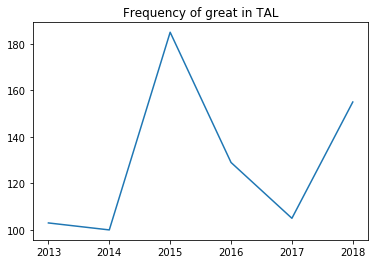

In [77]:
helper.plot_count(tal_df, before_elect + after_elect, 'great')

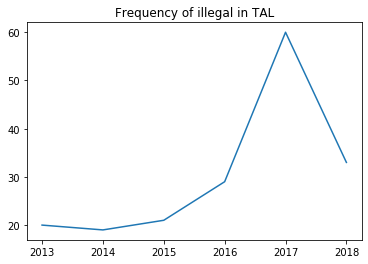

In [78]:
helper.plot_count(tal_df, before_elect + after_elect, 'illegal')

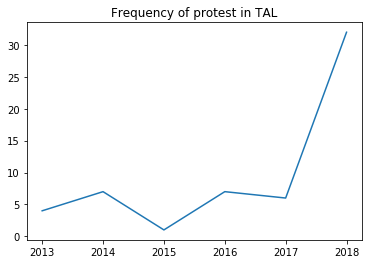

In [79]:
helper.plot_count(tal_df, before_elect + after_elect, 'protest')

In [ ]:
helper.plot_count(tal_df, before_elect + after_elect, 'white')

## Most Common Adj

In [80]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'trump')
    print(year)
    print(res)
    print()

/Users/katykoeing/Desktop/computational-content-analysis/nlp-tal/source/helper_functions.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['POS_sents'] = df.apply(lambda x: tag_sents_pos(x['tokenized_sents']), axis=1)


2013
{}

2014
{'following': 1}

2015
{}

2016
{'sure': 1, 'pro': 1, 'active': 1, 'gay': 1, 'short': 1, 'reluctant': 1, 'many': 1}

2017
{'pro': 2, 'hardcore': 1, 'early': 1}

2018
{'12.The': 1, 'anti': 1}



In [136]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'protest')
    print(year)
    print(res)
    print()

2013
{'weekly': 2}

2014
{'public': 1}

2015
{'first': 1}

2016
{}

2017
{'silly': 1}

2018
{}



In [81]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'america')
    print(year)
    print(res)
    print()

2013
{}

2014
{'colonial': 1}

2015
{'conformist': 1, 'middle': 1}

2016
{'whole': 1, 'great': 1}

2017
{'noble': 1, 'white': 1}

2018
{'new': 1, 'white': 2, 'red': 1, 'blue': 1, 'whole': 1}



In [82]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'government')
    print(year)
    print(res)
    print()

2013
{'other': 1, 'Honduran': 4, 'mini': 1, 'inept': 1, 'local': 1, 'entire': 1, 'federal': 23, 'different': 1, 'Roman': 2, 'Eritrean': 1, 'Israeli': 1, 'central': 1, 'big': 1}

2014
{'Mexican': 1, 'federal': 2, 'anti': 1, 'small': 1, 'Afghan': 1, 'skeptical': 1, 'recent': 1}

2015
{'municipal': 2, 'Korean': 1, 'Kenyan': 1, 'federal': 3, 'corrupt': 1, 'Chinese': 1, 'own': 1, 'inside': 1}

2016
{'federal': 9, 'small': 1, 'big': 1, 'Greek': 8, 'entire': 2, 'secure': 2, 'Roman': 2}

2017
{'Iraqi': 1, 'other': 1, 'possible': 1, 'entire': 2, 'American': 1, 'Hawaiian': 1, 'own': 1, 'official': 1, 'anti': 1, 'Russian': 1, 'pro': 1, 'Chinese': 4, 'central': 2, 'federal': 7, 'Somali': 2, 'Japanese': 1, 'German': 1, 'local': 2, 'nationwide': 1}

2018
{'Korean': 1, 'Spanish': 1, 'Moroccan': 1, 'Mexican': 2, 'Kenyan': 2, 'limited': 1, 'big': 1, 'transitional': 1, 'real': 1}



In [101]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'american')
    print(year)
    print(res)
    print()

2013
{'North': 2, 'Italian': 1, 'enormous': 1, 'dirty': 1, 'African': 6, 'distressed': 1, 'nice': 1}

2014
{'perfect': 1, 'cheesy': 1, 'Mexican': 1, 'Native': 3, 'celebrated': 1, 'African': 4, 'nice': 1, 'other': 1, 'healthy': 1}

2015
{'young': 1, 'ugly': 1, 'late': 1, 'wonderful': 1, 'proud': 2, 'new': 1, 'African': 8, 'major': 1, 'Native': 1, 'Central': 1, 'other': 1, 'white': 1, 'black': 1, 'first': 1, 'old': 1, 'long': 1, 'lonely': 1, 'real': 1, 'South': 2}

2016
{'African': 1, 'real': 1, 'Iranian': 1, 'Nigerian': 2, 'Spanish': 1, 'new': 1, 'exaggerated': 1, 'stupid': 1, 'anti': 1, 'average': 1, 'strong': 1}

2017
{'small': 1, 'new': 1, 'several': 1, 'African': 2, 'black': 1, 'strong': 1, 'mini': 1, 'first': 1, 'Native': 1}

2018
{'Native': 1, 'private': 1, 'African': 11, 'Latin': 1, 'Central': 2, 'sprint': 1, 'old': 2, 'entire': 1, 'quintessential': 1, 'Chinese': 1, 'Iranian': 1, 'Many': 1}



In [200]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'mexican')
    print(year)
    print(res)
    print()

2013
{}

2014
{'desirable': 1, 'preppy': 1, 'tiny': 1}

2015
{}

2016
{}

2017
{'major': 1, 'Naomi': 1, 'undocumented': 1, 'single': 1, 'only': 1}

2018
{'undocumented': 1, 'tiny': 1}



In [106]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'court')
    print(year)
    print(res)
    print()

2013
{'federal': 2}

2014
{'rabbinic': 3, 'original': 1, 'magistrate': 1, 'full': 1, 'impending': 1, 'federal': 1}

2015
{'rabbinic': 3}

2016
{'federal': 1, 'appellate': 1, 'faxed': 1, 'first': 1, 'criminal': 1}

2017
{'municipal': 1, 'actual': 1, 'federal': 5, 'appellate': 1}

2018
{'big': 1, 'criminal': 3, 'federal': 1}



In [107]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'election')
    print(year)
    print(res)
    print()

2013
{'judicial': 1, 'presidential': 1}

2014
{'last': 1}

2015
{'main': 1}

2016
{'enjoyable': 1, 'perfect': 1, 'presidential': 6, 'daily': 1, 'mock': 1, 'awful': 1}

2017
{'future': 1, 'bitter': 1, 'primary': 1, 'congressional': 1, 'presidential': 4, 'next': 2}

2018
{'presidential': 1, 'general': 3, 'last': 1}



In [110]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'white')
    print(year)
    print(res)
    print()

2013
{'whole': 1, 'pinkish': 1, 'red': 1, 'great': 1, 'crisp': 2, 'few': 1, 'plain': 1, 'big': 1, 'other': 3, 'young': 1, 'youngish': 2, 'average': 2, 'black': 2, 'angry': 1, 'murderous': 2, 'white': 1, 'old': 1}

2014
{'blind': 1, 'light': 1, 'black': 3, 'red': 1, 'petite': 1, 'rich': 1, 'big': 1, 'huge': 1, 'many': 1}

2015
{'tiny': 1, 'short': 1, 'unarmed': 1, 'black': 4, 'young': 3, 'many': 1, 'blind': 1, 'light': 1, 'little': 1, 'blonde': 1, 'private': 1, 'enough': 1, 'racist': 1, 'clean': 1, 'poor': 2, 'crazy': 1, 'massive': 1, 'only': 1, 'difficult': 1, 'small': 2, 'few': 1, 'encouraging': 1, 'other': 1, 'old': 1, 'sheltered': 1, 'mainstream': 1}

2016
{'old': 1, 'little': 3, 'many': 1, 'first': 1, 'ugly': 1, 'red': 1, 'other': 1, 'bright': 1, 'pure': 3, 'plain': 2, 'wild': 2, 'brilliant': 2}

2017
{'annual': 1, 'young': 1, 'mysterious': 1, 'red': 1, 'huge': 1, 'bright': 1, 'old': 1, 'burly': 1, 'wealthy': 1, 'Caucasian': 1, 'southern': 1, 'aged': 1, 'super': 1, 'basic': 1, 'unq

In [111]:
for year in by_year_elect.keys():
    df = by_year_elect[year]
    res = helper.most_common_adj(df, 'public')
    print(year)
    print(res)
    print()

2013
{'typical': 1, 'many': 1, 'free': 1, 'first': 1, 'own': 1, 'lewd': 1, 'massive': 1}

2014
{'many': 1, 'genuine': 1, 'general': 1, 'fellow': 2, 'other': 1, 'pro': 1, 'traditional': 1, 'shuttered': 1, 'unquote': 1, 'local': 1, 'non': 1, 'single': 1, 'chaotic': 1}

2015
{'local': 1, 'new': 1, 'crowded': 1, 'American': 3, 'poor': 1, 'many': 1, 'big': 1, 'awesome': 1, 'Japanese': 1, 'secret': 1, 'regular': 2, 'general': 1, 'experienced': 1, 'racist': 1}

2016
{'general': 1, 'nice': 1, 'enough': 1, 'chief': 2, 'normal': 1}

2017
{'other': 1, 'awkward': 1, 'free': 1, 'regular': 2, 'local': 2, 'anti': 1, 'traditional': 4, 'whole': 1, 'great': 1, 'cheerful': 1, 'photo': 1, 'big': 1}

2018
{'much': 1, 'general': 2, 'vicious': 1, 'federal': 1, 'other': 1, 'deliberate': 1, 'regular': 1, 'only': 1}



## Word Networks

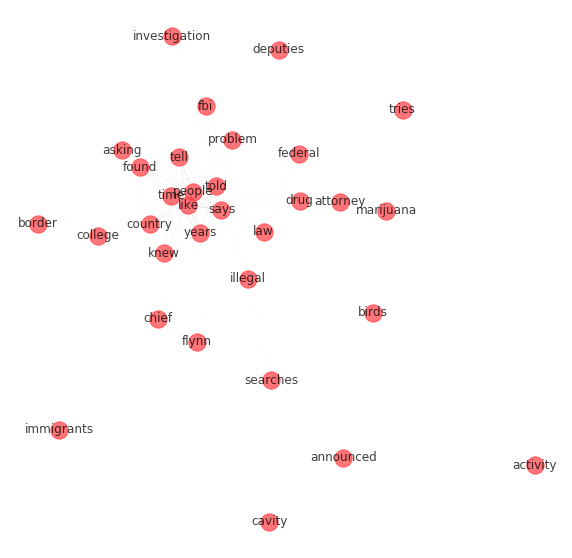

In [177]:
helper.graph_nx_word(before_elect_df, 'no_lemma_normalized_sents', 2, 'illegal')

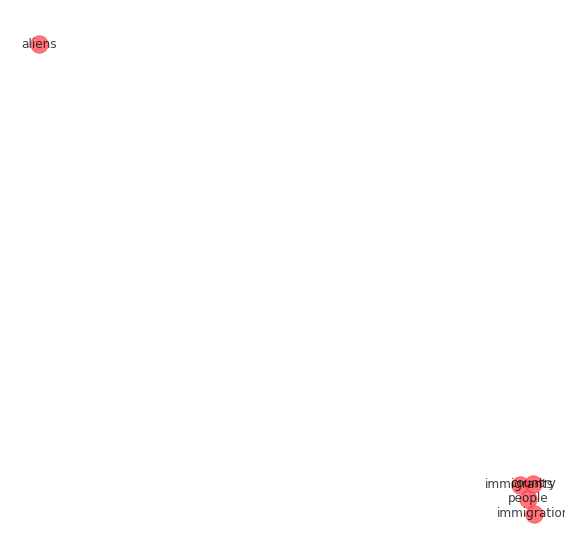

In [180]:
helper.graph_nx_word(after_elect_df, 'no_lemma_normalized_sents', 8, 'illegal')

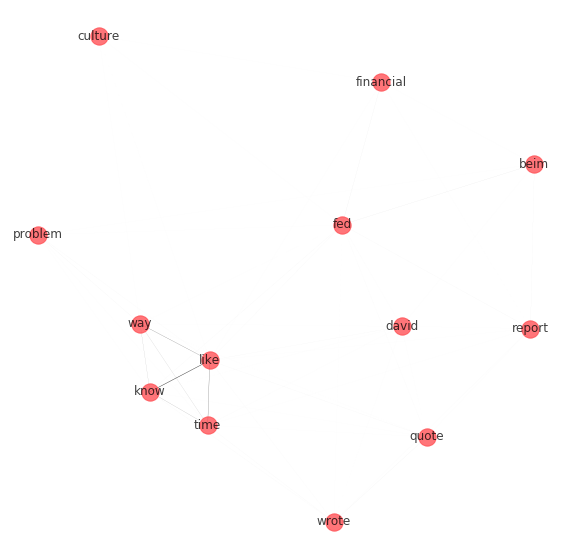

In [204]:
helper.graph_nx_word(before_elect_df, 'no_lemma_normalized_sents', 2, 'crisis')

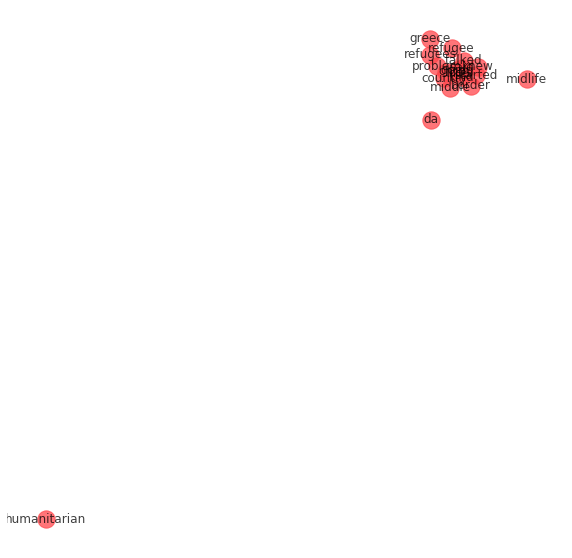

In [203]:
helper.graph_nx_word(after_elect_df, 'no_lemma_normalized_sents', 2, 'crisis')

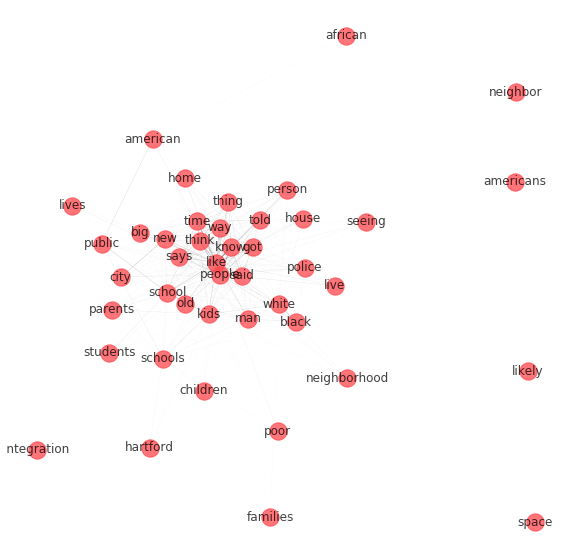

In [208]:
helper.graph_nx_word(before_elect_df, 'no_lemma_normalized_sents', 7, 'white')

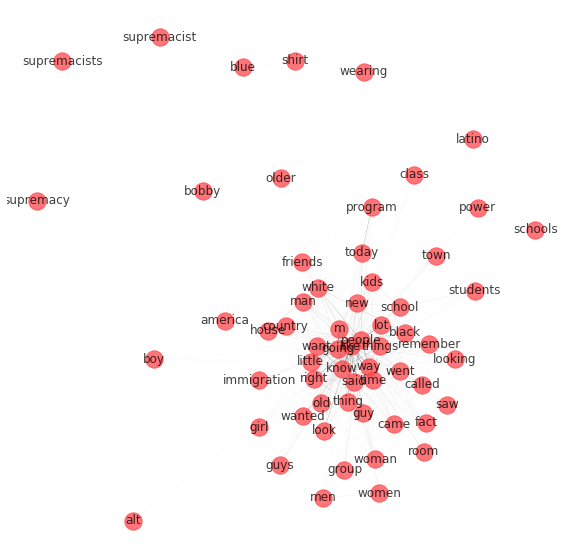

In [209]:
helper.graph_nx_word(after_elect_df, 'no_lemma_normalized_sents', 7, 'white')

## Embedding Bias

In [87]:
# create representative group 
# male
male = ['he', 'son', 'boys', 'boy', 'male', 'man', 'men', 'his', 'nephew',
        'nephews', 'brother', 'brothers', 'father', 'uncle', 'uncles', 'himself']
# female, from the Garg paper
female = ['she', 'daughter', 'hers', 'her', 'mother', 'woman', 'girl', 'herself',
          'female', 'females', 'sister', 'daughters', 'mothers',
          'women', 'girls', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
# rich
rich = ['rich', 'wealthy', 'wealth', 'expensive', 'affluent', 'affluence', 'afford']
# poor
poor = ['poor', 'cheap', 'poverty', 'broke']

In [90]:
# pre
talW2V_elect = gensim.models.word2vec.Word2Vec(before_elect_df['no_lemma_normalized_sents'].sum(), 
                                         size=1000)
elect_male_vec = helper.mk_rep_group_vec(talW2V_elect, male)
elect_female_vec = helper.mk_rep_group_vec(talW2V_elect, female)
elect_rich_vec = helper.mk_rep_group_vec(talW2V_elect, rich)
elect_poor_vec = helper.mk_rep_group_vec(talW2V_elect, poor)

In [91]:
# now try on post
talW2V01_elect = gensim.models.word2vec.Word2Vec(after_elect_df['no_lemma_normalized_sents'].sum(),
                                           size=1000)
elect_male_vec01 = helper.mk_rep_group_vec(talW2V01_elect, male)
elect_female_vec01 = helper.mk_rep_group_vec(talW2V01_elect, female)
elect_rich_vec01 = helper.mk_rep_group_vec(talW2V01_elect, rich)
elect_poor_vec01 = helper.mk_rep_group_vec(talW2V01_elect, poor)

In [92]:
# neutral word list
liberal = ['liberal', 'progressive', 'democrat'] 
conservative = ['conservative', 'republican']
finance = ['save', 'savings', 'loan', 'debt', 'bank',
           'banking', 'mortgage', 'money']
anger = ['angry', 'mad', 'hate', 'anger', 'disgust']
fear = ['scared', 'fear', 'scary', 'afraid']
happy = ['happy', 'excited', 'enjoy', 'enjoying']
sad = ['sad', 'unhappy', 'tears']

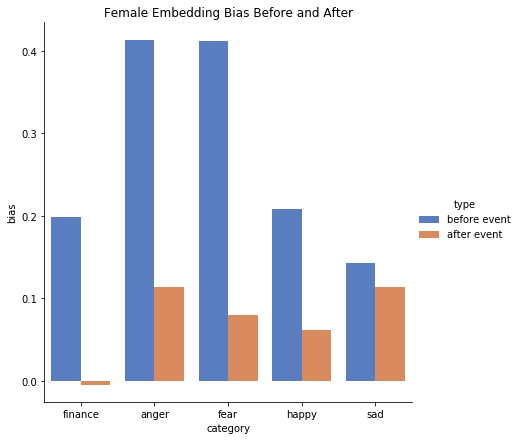

In [93]:
wordlist_dict = {'finance': finance, 'anger': anger,
                 'fear': fear, 'happy': happy, 'sad': sad}
pre_dict = {'model': talW2V, 'group_vec': female_vec,
            'compare_vec': male_vec}
post_dict = {'model': talW2V01, 'group_vec': female_vec01,
             'compare_vec': male_vec01}

helper.plot_bias(pre_dict, post_dict,
                 'Female Embedding Bias Before and After',
                 wordlist_dict)

## Most similar

In [201]:
most_similar_election = helper.agg_sim_words([talW2V_elect, talW2V01_elect],
                     ['before election', 'after after'], elect_word1 + elect_word2)
most_similar_election.head()

,security,immigration,immigrant,illegal,protest,decency,wall,china,trade,great,...,mexico,love,hate,america,american,country,safe,family,home,period
0,"[(according, 0.999903678894043), (pages, 0.999...","[(documents, 0.999925971031189), (investigatio...","[(road, 0.9999195337295532), (mcneil, 0.999909...","[(iraq, 0.9999101161956787), (officially, 0.99...","[(interviews, 0.9998399019241333), (subject, 0...",NA,"[(seat, 0.9999144077301025), (charge, 0.999898...","[(continued, 0.9999092221260071), (egypt, 0.99...","[(bills, 0.9999239444732666), (70s, 0.99991118...","[(sound, 0.9995348453521729), (mind, 0.9993659...",...,"[(moved, 0.9991026520729065), (hypothesis, 0.9...","[(to--, 0.9987203478813171), (totally, 0.99856...","[(obvious, 0.9998466968536377), (cause, 0.9998...","[(regular, 0.999905526638031), (cracked, 0.999...","[(wbez, 0.9830749034881592), (public, 0.975195...","[(francisco, 0.9996967911720276), (reported, 0...","[(fuck, 0.99985671043396), (sleep, 0.999822437...","[(reminds, 0.9989326000213623), (finally, 0.99...","[(bedroom, 0.9989762902259827), (morning, 0.99...",before election
1,"[(government, 0.9991199970245361), (immigratio...","[(security, 0.9990454316139221), (government, ...","[(cloud, 0.9998400211334229), (st, 0.999824285...","[(legislature, 0.9997485876083374), (officials...","[(ordered, 0.9999126195907593), (picked, 0.999...","[(fuel, 0.9998359084129333), (launch, 0.999825...","[(orange, 0.9997844696044922), (autopsy, 0.999...","[(concrete, 0.9998615980148315), (entirely, 0....","[(d, 0.9998603463172913), (jqc, 0.999853372573...","[(nice, 0.9991393089294434), (sadness, 0.99905...",...,"[(seat, 0.9996793866157532), (representatives,...","[(need, 0.9978838562965393), (let, 0.997750222...","[(cop, 0.9998995661735535), (presence, 0.99989...","[(power, 0.9997929334640503), (ballot, 0.99967...","[(wbez, 0.9777863025665283), (chicago, 0.97535...","[(government, 0.9985477924346924), (security, ...","[(guilty, 0.9998350143432617), (imagine, 0.999...","[(college, 0.9985378384590149), (family--, 0.9...","[(college, 0.997954785823822), (graduate, 0.99...",after after


In [202]:
most_similar_election.to_csv('most_similar_election.csv', index=False)

## Plot Dimensions

In [95]:
# dimensions
Gender = helper.dimension(talW2V, ['man','guy', 'male'],
                          ['woman', 'girl', 'female'])
Race = helper.dimension(talW2V, ['black', 'brown', 'minority'],
                        ['white'])
Class = helper.dimension(talW2V, ['rich', 'expensive', 'wealth'],
                         ['poor', 'cheap', 'poor'])

Morality = helper.dimension(talW2V, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education = helper.dimension(talW2V, ['educated','smart'], 
                             ['dumb','stupid'])
dim_dict = {'gender': Gender, 'race': Race, 'class': Class,
            'morality': Morality, 'education': Education}

In [96]:
# word lists
emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
            'embarrassed', 'hate', 'love', 'anger', 'upset',
            'tired', 'lazy', 'hope']

opinions = ['believe', 'belief', 'perspective', 'opinion',
            'thought', 'think', 'attitude']

self = ['self', 'appearance', 'looks', 'confidence', 'gay',
        'black', 'white', 'american']

rel = ['single', 'divorce', 'divorced', 'family', 'brother',
       'sister', 'children', 'aunt', 'uncle',
       'child', 'wedding', 'married', 'marriage', 'boyfriend',
       'girlfriend', 'partner', 'love']

In [97]:
emotions = ['scared', 'secure', 'nervous', 'hopeful', 'security']
Emodf = helper.makeDF(talW2V_elect, emotions, dim_dict)
Opdf = helper.makeDF(talW2V_elect, opinions, dim_dict)
Selfdf = helper.makeDF(talW2V_elect, self, dim_dict)
Reldf = helper.makeDF(talW2V_elect, rel, dim_dict)

Emotions


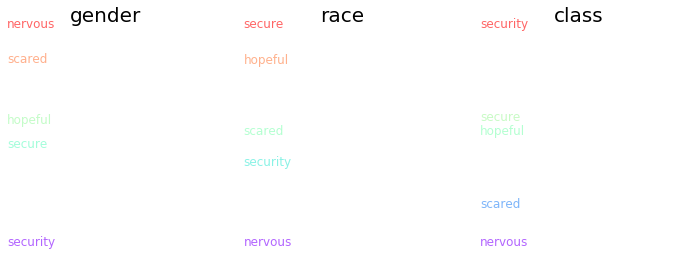

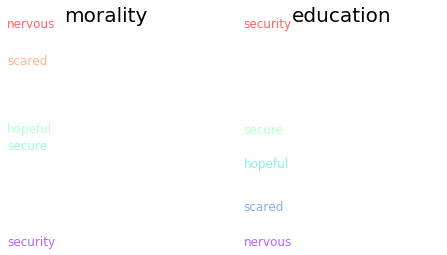

In [98]:
# Pre
# display words on dimensions
print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
helper.PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'education')
plt.show()

In [99]:
# post dimensions
Gender01 = helper.dimension(talW2V01_elect, ['man','guy', 'male','brother','father', 'son'], 
                            ['woman', 'girl', 'female','sister', 'mother','daughter'])
Race01 = helper.dimension(talW2V01, ['black','blacks', 'brown'],
                          ['white', 'whites'])
Class01 = helper.dimension(talW2V01_elect, ['rich', 'expensive', 'wealthy'],
                           ['poor', 'cheap', 'poor'])

Morality01 = helper.dimension(talW2V01_elect, ['good', 'good', 'honest','pure'], 
                             ['bad', 'evil','lie','dirty'])

Education01 = helper.dimension(talW2V01_elect, ['educated', 'smart', 'college'], 
                              ['dumb', 'stupid'])
dim_dict01 = {'gender': Gender01, 'race': Race01, 'class': Class01,
              'morality': Morality01, 'education':  Education01}

Emotions


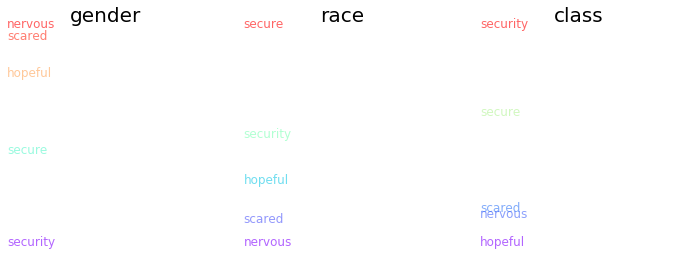

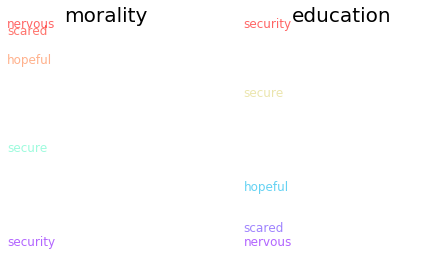

In [100]:
Emodf = helper.makeDF(talW2V01_elect, emotions, dim_dict01)
Opdf = helper.makeDF(talW2V01_elect, opinions, dim_dict01)
Selfdf = helper.makeDF(talW2V01_elect, self, dim_dict01)
Reldf = helper.makeDF(talW2V01_elect, rel, dim_dict01)


print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
helper.PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'education')
plt.show()

## Event 1: 9/11

Words of interest:

In [12]:
# words of interest for this event
word1 = ['iraq', 'iraqi', 'iraqis', 'afghanistan', 'qaeda', 'weapon', 'weapons', 'muslim', 'muslims', 
         'terrorist', 'terrorism', 'terror', 'panic', 'war', 'hate', 'soldier', 'soldiers', 
         'ally', 'allies', 'security', 'secure']
word2 = ['love', 'america', 'american', 'country', 'safe', 'family', 'home']

In [4]:
# load 1998 to 2003 dataframe
# it has POS_sents saved to it because that takes awhile to run and is used in most common adjectives
tal_df = pd.read_csv('trans_total_pos_98-03.csv', converters = {'tokenized_sents': literal_eval,'no_lemma_normalized_sents': literal_eval,
                'normalized_sents':literal_eval,'tokenized_text':literal_eval,
                'normalized_tokens':literal_eval,'no_lemma_normalized_tokens':literal_eval, 'POS_sents': literal_eval})

## Split text into periods

In [5]:
# prep text
df98 = tal_df[tal_df.year==1998]
df99 = tal_df[tal_df.year==1999]
df00 = tal_df[tal_df.year==2000]
df01 = tal_df[tal_df.year==2001]
df02 = tal_df[tal_df.year==2002]
df03 = tal_df[tal_df.year==2003]

In [6]:
grouped = tal_df[(tal_df.year==1998) | (tal_df.year==1999) | (tal_df.year==2000)]

In [8]:
grouped2 = tal_df[(tal_df.year==2001) | (tal_df.year==2002) | (tal_df.year==2003)]

## Subject/object for verbs

In [7]:
# for 1998-2000 - takes awhile to run
x = helper.make_verb_dict('hate', grouped)
x

{'1998': (['they',
   'people',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'I',
   'people',
   'she',
   'I',
   'I',
   'they',
   'We',
   'I',
   'I',
   'I',
   'I',
   'I',
   'you',
   'I',
   'I',
   'I',
   'I',
   'I'],
  ['What',
   'past',
   'room',
   'guts',
   'brothers',
   'him',
   'tits',
   'word',
   'Carrey',
   'him',
   'falls',
   'them',
   'place',
   'life',
   'column',
   'you',
   'you',
   'you',
   'you',
   'Timberlands']),
 '1999': (['you', 'I', 'they', 'you', 'I'], ['act', 'him']),
 '2000': (['They',
   'I',
   'brother',
   'I',
   'brother',
   'I',
   'I',
   'I',
   'who',
   'everyone',
   'They',
   'she',
   'they',
   'I',
   'I',
   'I',
   'I',
   'who',
   'I',
   'I',
   'I',
   'me'],
  ['you',
   'brother',
   'myself',
   'brother',
   'myself',
   'it',
   'club',
   'me',
   'you?I',
   'Bradley',
   'you',
   'people',
   'them',
   'them',
   'guts',
   'him',
   'him',
   'couple',
   'them',
   't

In [10]:
# 2001-2003 - takes awhile to run
z=helper.make_verb_dict('hate', grouped2)

In [16]:
z

{'2001': (['you',
   'I',
   'I',
   'he',
   'who',
   'we',
   'I',
   'I',
   'I',
   'I',
   'people',
   'people',
   'I',
   'you',
   'I',
   'I',
   'You',
   'I',
   'people',
   'I'],
  ['person',
   'him',
   'music',
   'it',
   'for--',
   'facts',
   'States',
   'olives',
   'them',
   'us',
   'it']),
 '2002': (['I',
   'who',
   'people',
   'I',
   'I',
   'I',
   'you',
   'we',
   'I',
   'physicists',
   'it',
   'I',
   'you',
   'I',
   'I',
   'I',
   'they',
   'you',
   'I',
   'people',
   'I',
   'you',
   'you',
   'He',
   'him',
   'you',
   'you',
   'you',
   'I',
   'I',
   'I',
   'I',
   'Americans',
   'Arabs'],
  ['you',
   'you',
   'you',
   'you',
   'torpedoes',
   'parents',
   'it',
   'pepper',
   'What',
   'fact',
   'it',
   'us',
   'Jews',
   'them',
   'people',
   'you',
   'men',
   'them',
   'it',
   'it',
   'it',
   'What',
   'house',
   'yourself',
   'it',
   'it',
   'way',
   'everything',
   'Islam',
   'him',
   'him']),
 

## Get common_contexts across years for a particular words

In [13]:
# takes awhile to run
y = helper.agg_contexts([df98,df99,df00,df01,df02,df03], [1998,1999,2000,2001,2002,2003], word2)

In [488]:
# save so you can compare more easily
y.to_csv('9_11_home_contexts.csv',index=False)

## Get frequency counts across years

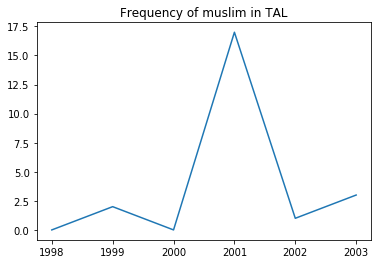

In [15]:
helper.plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'muslim')

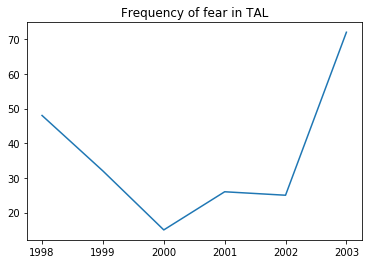

In [27]:
helper.plot_count(tal_df,[1998,1999,2000,2001,2002,2003],'fear')

## Most common adjectives

In [20]:
helper.most_common_adj(df98, 'war')

{'civil': 1, 'big': 1, 'anti': 1}

In [21]:
helper.most_common_adj(df99, 'war')

{'civil': 1, 'religious': 1, 'anti': 1}

In [22]:
helper.most_common_adj(df00, 'war')

{'active': 1}

In [23]:
helper.most_common_adj(df01, 'war')

{'civil': 2,
 'turf': 1,
 'other': 1,
 'mock': 1,
 'massive': 1,
 'coming': 1,
 'bloody': 1,
 'Israeli': 1,
 'American': 1,
 'current': 1,
 'unpopular': 1,
 'holy': 1}

In [24]:
helper.most_common_adj(df02, 'war')

{'overall': 1, 'nuclear': 1, 'successful': 1, 'likely': 1, 'narrow': 1}

In [25]:
helper.most_common_adj(df03, 'war')

{'previous': 1,
 'current': 1,
 'last': 1,
 'different': 1,
 'other': 1,
 'splendid': 1,
 'new': 1,
 'possible': 1,
 'first': 1,
 'bloody': 1,
 'preventive': 1,
 'anti': 3,
 'civil': 1,
 'political': 1,
 'little': 1,
 'holy': 2}

## Word networks

/Users/laurenli/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


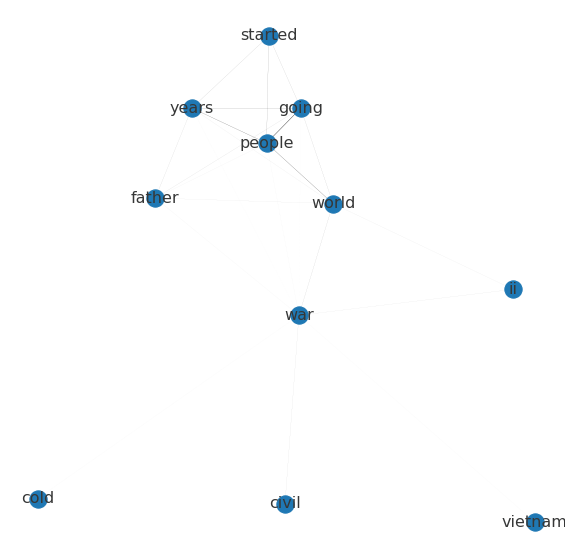

In [29]:
# pre 9/11
helper.graph_nx_word(grouped, 'no_lemma_normalized_sents', 5, 'war')

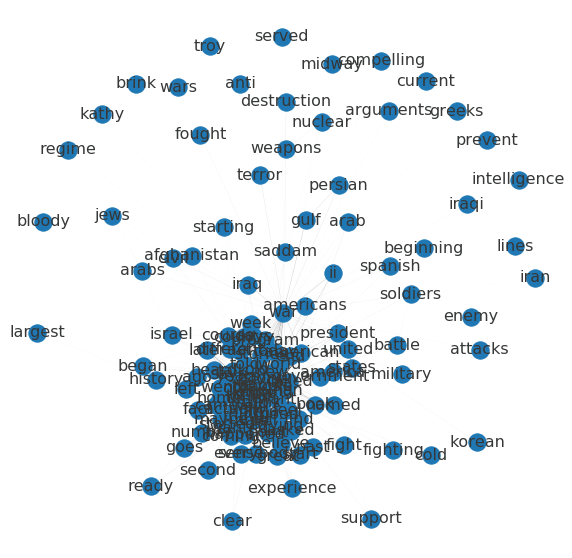

In [31]:
# post 9/11
helper.graph_nx_word(grouped2, 'no_lemma_normalized_sents', 5, 'war')

## Embedding Bias

Bias in the embeddings, between two groups with respect to a neutral word list, is quantified by the relative norm
difference, which is calculated as follows: (a) a representative group vector is created as the average of the vectors for
each word in the given gender/ethnicity group; (b) the average l2 norm of the differences between each representative
group vector and each vector in the neutral word list of interest is calculated; (c) the relative norm difference is the
difference of the average l2 norms. This metric captures the relative distance (and thus relative strength of association)
between the group words and the neutral word list of interest.


Negative bias means more associated with the group being subtracted

From: https://arxiv.org/pdf/1711.08412.pdf

In [33]:
# create representative group 
# male
male = ['he', 'son', 'boys', 'boy', 'male', 'man', 'men', 'his', 'nephew', 'nephews', 'brother', 'brothers',
       'father', 'uncle', 'uncles', 'himself']
# female, from the Garg paper
female = ['she', 'daughter', 'hers', 'her', 'mother', 'woman', 'girl', 'herself', 'female', 'females','sister', 'daughters', 'mothers',
          'women', 'girls', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
# rich
rich = ['rich', 'wealthy', 'wealth', 'expensive', 'affluent', 'affluence', 'afford']
# poor
poor = ['poor', 'cheap', 'poverty', 'broke']
    

In [34]:
# pre 911
talW2V = gensim.models.word2vec.Word2Vec(grouped['no_lemma_normalized_sents'].sum(),size=1000)

male_vec = helper.mk_rep_group_vec(talW2V, male)
female_vec = helper.mk_rep_group_vec(talW2V, female)
rich_vec = helper.mk_rep_group_vec(talW2V, rich)
poor_vec = helper.mk_rep_group_vec(talW2V, poor)

In [37]:
# now try on post 9/11
talW2V01 = gensim.models.word2vec.Word2Vec(grouped2['no_lemma_normalized_sents'].sum(),size=1000)

male_vec01 = helper.mk_rep_group_vec(talW2V01, male)
female_vec01 = helper.mk_rep_group_vec(talW2V01, female)
rich_vec01 = helper.mk_rep_group_vec(talW2V01, rich)
poor_vec01 = helper.mk_rep_group_vec(talW2V01, poor)

In [ ]:
# neutral word list (war? liberal, conservative)
liberal = ['liberal', 'progressive', 'democrat'] 
conservative = ['conservative','republican', '']
war = ['war', 'soldier', 'soldiers', 'fight', 'battle', 'battles', 'weapon', 'weapons', 'bomb', 'bombs', 'death']
anger = ['angry', 'mad', 'hate', 'anger', 'disgust']
fear = ['scared', 'fear', 'scary', 'afraid']
happy = ['happy', 'excited', 'enjoy', 'enjoying']
sad = ['sad', 'unhappy', 'tears']

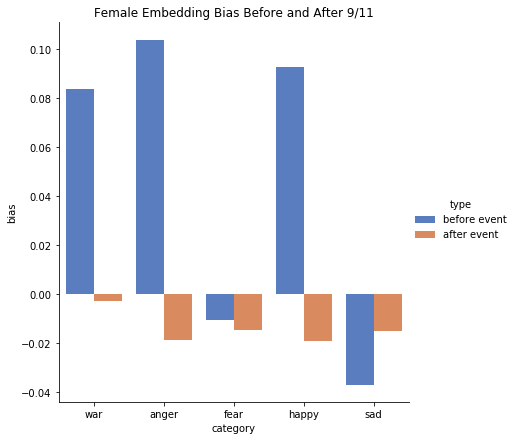

In [40]:
wordlist_dict = {'war': war, 'anger': anger, 'fear': fear, 'happy': happy, 'sad': sad}
pre_dict = {'model': talW2V, 'group_vec': female_vec, 'compare_vec': male_vec}
post_dict = {'model': talW2V01, 'group_vec': female_vec01, 'compare_vec': male_vec01}

helper.plot_bias(pre_dict, post_dict, 'Female Embedding Bias Before and After 9/11',wordlist_dict)

## Most similar words

2001

In [42]:
word_all = word1+word2

In [44]:
helper.agg_sim_words([talW2V, talW2V01], ['before 911', 'after 911'], word_all)

,iraq,iraqi,iraqis,afghanistan,qaeda,weapon,weapons,muslim,muslims,terrorist,...,security,secure,love,america,american,country,safe,family,home,period
0,NA,NA,NA,NA,NA,"[(sudden, 0.9989239573478699), (taking, 0.9989...",NA,NA,NA,NA,...,"[(committee, 0.9999585151672363), (al, 0.99995...","[(making, 0.9996501207351685), (rich, 0.999614...","[(true, 0.9976155757904053), (world, 0.9967904...","[(jay, 0.9998445510864258), (producers, 0.9998...","[(public, 0.989877462387085), (wbez, 0.9894055...","[(suburban, 0.9998255968093872), (police, 0.99...","[(bored, 0.999897837638855), (confused, 0.9998...","[(found, 0.9995360970497131), (small, 0.999501...","[(expense, 0.9985451698303223), (friends, 0.99...",before 911
1,"[(majority, 0.9999509453773499), (ideas, 0.999...","[(democrats, 0.9999638795852661), (papers, 0.9...","[(share, 0.999951183795929), (character, 0.999...","[(sports, 0.9999758005142212), (wear, 0.999972...","[(beat, 0.9999322295188904), (mary, 0.99993199...","[(connection, 0.9999487400054932), (drop, 0.99...","[(sex, 0.9999672174453735), (food, 0.999966204...","[(example, 0.9999345541000366), (political, 0....","[(date, 0.9999000430107117), (laugh, 0.9998935...","[(security, 0.999968409538269), (attacks, 0.99...",...,"[(clinton, 0.999980092048645), (authority, 0.9...","[(strange, 0.9998478889465332), (matter, 0.999...","[(ask, 0.9995733499526978), (talk, 0.999414443...","[(border, 0.999963641166687), (political, 0.99...","[(public, 0.9942607879638672), (liberacion, 0....","[(classifieds, 0.9998220205307007), (seattle, ...","[(losing, 0.9999561309814453), (legs, 0.999953...","[(moved, 0.9997044801712036), (took, 0.9995684...","[(house, 0.9995330572128296), (night, 0.999291...",after 911


## Plotting dimensions as in hw7

In [45]:
# dimensions
Gender = helper.dimension(talW2V, ['man','guy', 'male'], ['woman', 'girl', 'female'])
Race = helper.dimension(talW2V, ['black','blacks', 'brown', ], ['white', 'whites', 'white', 'white'])
Class = helper.dimension(talW2V, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap', 'poor'])

Morality = helper.dimension(talW2V, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education = helper.dimension(talW2V, ['educated','smart'], 
                      ['dumb','stupid'])
dim_dict = {'gender': Gender, 'race': Race, 'class': Class, 'morality':Morality, 'education':Education}

In [46]:
# word lists
emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
            'embarrassed', 'hate', 'love', 'anger', 'upset', 'tired', 'lazy', 'dread', 'hope']

opinions = ['believe', 'belief', 'perspective', 'opinion', 'thought', 'think', 'attitude']

self=['self', 'appearance', 'looks', 'confidence', 'perception', 'gay', 
      'lesbian', 'black', 'white', 'american', 'exotic']

rel=['single', 'divorce', 'divorced', 'family', 'brother', 'sister', 'children', 'aunt', 'uncle',
     'child', 'wedding', 'married', 'marriage', 'boyfriend', 'girlfriend', 'partner', 'love']



In [47]:
# make dataframe with emotions and dimensions for pre 9/11
Emodf = helper.makeDF(talW2V, emotions, dim_dict)
Opdf = helper.makeDF(talW2V, opinions, dim_dict)
Selfdf = helper.makeDF(talW2V, self, dim_dict)
Reldf = helper.makeDF(talW2V, rel, dim_dict)

Emotions


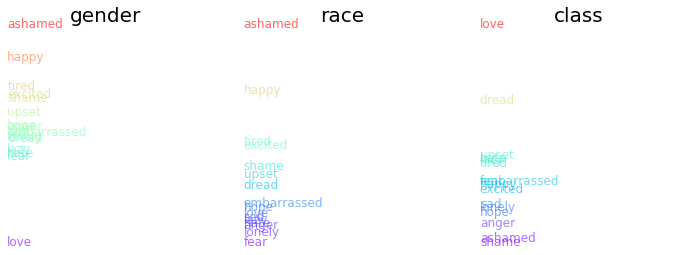

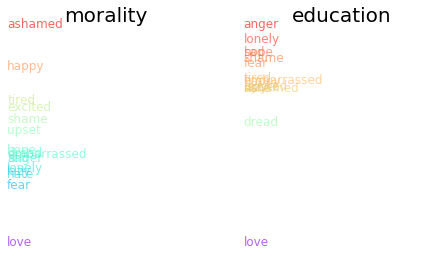

In [48]:
# display words on dimensions
print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
helper.PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'education')
plt.show()

In [49]:
## now will look at 2001-2003

# dimensions
Gender01 = helper.dimension(talW2V01, ['man','guy', 'male','brother','father', 'son'], 
                            ['woman', 'girl', 'female','sister', 'mother','daughter'])
Race01 = helper.dimension(talW2V01, ['black','blacks', 'brown', ], ['white', 'whites', 'white', 'white'])
Class01 = helper.dimension(talW2V01, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap', 'poor'])

Morality01 = helper.dimension(talW2V01, ['good', 'good', 'honest','pure'], 
                     ['bad', 'evil','lie','dirty'])

Education01 = helper.dimension(talW2V01, ['educated','smart'], 
                      ['dumb','stupid'])
dim_dict01 = {'gender': Gender01, 'race': Race01, 'class': Class01, 'morality':Morality01, 'education':Education01}

Emotions


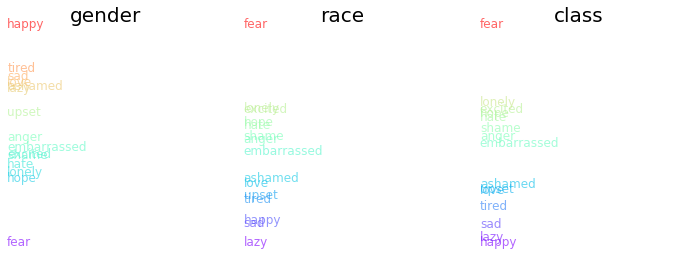

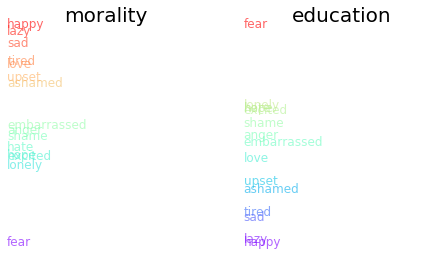

In [50]:
# now will 2001-2003
emotions = ['happy', 'sad', 'excited','fear', 'lonely', 'ashamed', 'shame', 
            'embarrassed', 'hate', 'love', 'anger', 'upset', 'tired', 'lazy', 'hope']
Emodf = helper.makeDF(talW2V01, emotions, dim_dict01)
Opdf = helper.makeDF(talW2V01, opinions, dim_dict01)
Selfdf = helper.makeDF(talW2V01, self, dim_dict01)
Reldf = helper.makeDF(talW2V01, rel, dim_dict01)


print('Emotions')
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'gender')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'race')
ax3 = fig.add_subplot(133)
helper.PlotDimension(ax3, Emodf, 'class')
plt.show()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
helper.PlotDimension(ax1, Emodf, 'morality')
ax2 = fig.add_subplot(132)
helper.PlotDimension(ax2, Emodf, 'education')
plt.show()